In [1]:
library(data.table)
library(Seurat)
library(ggplot2)
library(grid)
library(dplyr)
library(pheatmap)
library(DoubletFinder)
library(ggpubr)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)
library(BSgenome.Hsapiens.UCSC.hg19)
library(robustbase)
library(gridExtra)
library(RColorBrewer)
library(stringr)
library(monocle)
library(MAST)
library(tibble)
library(fgsea)
library(ggpubr)
library(GEOquery)
library(AUCell)
library(stringr)
library(circlize)
library(ComplexHeatmap)
library(monocle3)
library(fgsea)
library(GEOquery)
library(stringr)
library(extraDistr)
library(entropy)
library(writexl)

source("../src/motif_analysis.R")
source("../src/process_pdac.R")
source("../src/pdac_plots.R")
base_path <- file.path("..","data")



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: GenomicFeatures

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname

The cell below loads the cell annotations and creates a Seurat object from the publicly available read count matrix. 

Two files --- cell_doublets.tsv and edge_info_all_doublet_filtered_celltypes.rds --- which contain (a) the list of doublet cells to be removed from the Seurat object, and (b) the edge/non-edge annotations for each cell. 

In [2]:
base_path <- file.path("..","data")
pdac_matrix_file_name <- "CRA001160.matrix"
pdac_anno_file_name <- "CRA001160.celltypes.tsv"
pdac_matrix_path <- file.path( base_path, pdac_matrix_file_name )
pdac_annotation_path <- file.path( base_path, pdac_anno_file_name )

pdac_anno_dt <- process_annotations( pdac_annotation_path )
seurat_obj <- create_full_seurat_object( read_gene_exp_mat( 
    pdac_matrix_path ), pdac_anno_dt )
meta_data_dt <- data.table( seurat_obj@meta.data, keep.rownames = T ) %>% setnames(.,"rn","cell.name")

doublet_cells <- fread( file.path( base_path, "cell_doublets.tsv" ),header=F) %>% .$V1

filtered_cells <- meta_data_dt[!cell.name %in% doublet_cells,cell.name]
pdac_anno_dt <- pdac_anno_dt[cell.name %in% filtered_cells,]

seurat_obj <- subset( seurat_obj, cells=filtered_cells )
seurat_obj <- NormalizeData( seurat_obj )
meta_data_dt <- data.table( seurat_obj@meta.data, keep.rownames = T ) %>% setnames(.,"rn","cell.name")
edge_info_all <- readRDS( file.path( base_path, "edge_info_all_doublet_filtered_celltypes.rds" ) )

s.genes <- c("MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG","GINS2","MCM6","CDCA7","DTL","PRIM1","UHRF1","MLF1IP","HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7","POLD3","MSH2","ATAD2","RAD51","RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM","CASP8AP2","USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8")
g2m.genes <- c("HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A","NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF","TACC3","FAM64A","SMC4","CCNB2","CKAP2L","CKAP2","AURKB","BUB1","KIF11","ANP32E","TUBB4B","GTSE1","KIF20B","HJURP","CDCA3","HN1","CDC20","TTK","CDC25C","KIF2C","RANGAP1","NCAPD2","DLGAP5","CDCA2","CDCA8","ECT2","KIF23","HMMR","AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF","NEK2","G2E3","GAS2L3","CBX5","CENPA")


Warning message in fread(matrix_path):
“Detected 57530 column names but the data has 57531 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Run edge pipeline on all non-malignant cell types

In [36]:
all_cell_types <- unique(pdac_anno_dt$cluster)
across_refs_edge_center_dt <- data.table()
num_pcs = 50

source("../src/process_pdac.R")
malignant_cell_types <- c("Ductal cell type 2")
normal_cell_types <- setdiff( unique(pdac_anno_dt$cluster), malignant_cell_types)
edge_info_all <- add_edge_center_annotation_classic( seurat_obj, malignant_cell_types=malignant_cell_types, 
                                  normal_cell_types=normal_cell_types, num_pcs=num_pcs, 
                                  perform_control=T, no_tumour_adjacent=F, sample_info_column="orig.ident" )

saveRDS(edge_info_all,"edge_info_all_doublet_filtered_celltypes.rds")


[1] "Stellate cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "Macrophage cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "Endothelial cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "T cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "B cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "Fibroblast cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "Endocrine cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "Ductal cell type 1"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



[1] "Acinar cell"


Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"
[1] "40/100"
[1] "50/100"
[1] "60/100"
[1] "70/100"
[1] "80/100"
[1] "90/100"
[1] "100/100"


Centering and scaling data matrix



## Figure S1

This is a heatmap showing the distribution of the fraction of cells that each type that are contributed by each sample.

In [77]:
seurat_obj <- FindVariableFeatures(seurat_obj) %>% ScaleData %>% RunPCA(npcs=50,verbose=F) %>% RunUMAP(dims=1:50,verbose=F)
fig_s1_umap <- DimPlot( seurat_obj, group.by="cluster", label=T ) + theme(legend.position="none")

sample_info_df <- seurat_obj@meta.data %>% dplyr::select(orig.ident,cluster)
per_sample_count_df <- group_by(sample_info_df,cluster,orig.ident) %>% dplyr::count() %>% ungroup  
total_cell_count_df <- group_by(per_sample_count_df,cluster) %>% summarize(n_total=sum(n)) %>%
merge(.,per_sample_count_df,by="cluster") %>% mutate(cell_frac=n/n_total) %>% 
dplyr::select(cluster,orig.ident,cell_frac,n)


total_cell_frac_mat <- tidyr::pivot_wider(total_cell_count_df %>% dplyr::select(-n),names_from="orig.ident",
                                          values_from="cell_frac") %>% tibble::column_to_rownames("cluster") %>% as.matrix
total_cell_frac_mat <- total_cell_frac_mat[,c(paste0("N",1:11),paste0("T",1:24))]

options(repr.plot.width=6,repr.plot.height=12)
#Since the cell type fractions vary in a very short range, we need to log-scale them in order to get a usable
#heatmap for display.
max_frac <- max(apply(log(total_cell_frac_mat),1,function(x){return(max(na.omit(x)))}))
min_frac <- min(apply(log(total_cell_frac_mat),1,function(x){return(min(na.omit(x)))}))
colors <- colorRamp2(c(min_frac,max_frac),c("#87ceeb","#ffa500"))
values <- c(-10,-8,-6,-4,-2,0)

p_heatmap <- Heatmap(log(total_cell_frac_mat),cluster_rows=F,cluster_columns=F,name="fraction",col=colors,
                     na_col="black",
       rect_gp = gpar(col = "black", lwd = 2),
    top_annotation = HeatmapAnnotation(
        Fraction = 1:35,
        annotation_legend_param = list(col_fun = colors, title = "Fraction", at = values,
           labels=formatC(exp(values),format="e"))))

fig_S1_umap_heatmap <- grid.arrange(
    arrangeGrob(fig_s1_umap,
    grid.grabExpr(draw(p_heatmap)),
     widths=c(1,2),
    ncol=2
))
ggsave("Fig-supplement-umap.svg",fig_S1_umap_heatmap,height=6,width=24)

`summarise()` ungrouping output (override with `.groups` argument)



## Figures 1,C,D

These are UMAP plots of acinar cells colored by edge/non-edge labels (Figure 1C) and by sample of origin (Figure 1D). Given the large number of samples from which the cells come from, we don't display the sample labels. 

In [289]:
umap_plots <- list()
umap_plots2 <- list()
names_vec <- c("Acinar cell"="Acinar","Ductal cell type 1"="Ductal")
for (cell_type in c("Acinar cell","Ductal cell type 1")) {
        subset_obj <- subset( seurat_obj, cells=WhichCells(seurat_obj,expression=cluster == cell_type) )
    subset_obj <- AddMetaData(subset_obj,
                             merge(tibble::rownames_to_column(subset_obj@meta.data,"cell.name"),
                                  edge_info_all$edge_center_dt[,.(cell.name,cell_category)],by="cell.name") %>%
                             tibble::column_to_rownames("cell.name"))

    subset_obj <- FindVariableFeatures(subset_obj,nfeatures=1000) %>% ScaleData %>% RunPCA(.,npcs=50) %>%
    RunUMAP(.,dims=1:50)
    umap_plots[[cell_type]] <- DimPlot( subset_obj, group.by="cell_category" ) + 
    theme_pubr(base_size=13.33) + theme(legend.position="none") + ggtitle(names_vec[cell_type])
    if (cell_type == "Acinar cell") {
        umap_plots2[[cell_type]] <- DimPlot( subset_obj, group.by="orig.ident" ) + 
    theme_pubr(base_size=13.33) + ggtitle(names_vec[cell_type]) + theme(legend.position="none")
    }

}
rm(subset_obj)
ggsave( "Fig1-UMAPs.svg", ggarrange( plotlist=umap_plots, nrow=1, ncol=2, common.legend=F ), 
       width=5,height=2.5)
ggsave( "Fig1-UMAPs-by-sample.svg", ggarrange( plotlist=umap_plots2, nrow=1, ncol=1, common.legend=F ), 
       width=2.5,height=2.5)

Centering and scaling data matrix

PC_ 1 
Positive:  SAT1, S100A6, B2M, S100A11, TMSB10, EEF1A1, TMSB4X, SOD2, OLFM4, RPL15 
	   RPL28, FTH1, ACTG1, RPS19, RPS27, HLA-B, RPL13A, MMP7, RPS6, IL32 
	   RPS18, UBD, C3, MALAT1, RPL3, TM4SF1, RPS3, TACSTD2, HLA-C, RPS9 
Negative:  CELA3B, PRSS3, INS, FGL1, PDK4, SNTG2, CLPSL1, MT1G, IAPP, MT1H 
	   RGS2, RP11-462G2.1, EPHB3, G6PC2, SCGB1B2P, DPT, HMGCS2, COCH, RP11-799P8.1, DHRS2 
	   CHAC1, ABCC8, CHGA, DLK1, RPS4Y1, GAD2, CCDC105, ADCYAP1, FAM159B, PCDH10 
PC_ 2 
Positive:  REG1A, CTRB2, REG1B, REG3G, CUZD1, REG3A, IL32, RPS2, C15orf48, IGLL5 
	   PRSS3, LDHB, OLFM4, PGM1, GSTA1, CD52, NNMT, FXYD3, SERPINB1, DNAJC12 
	   GSTA2, VIM, C3, TFF1, FSCN2, ANXA10, FBXO2, CXCR4, COL3A1, LTB 
Negative:  FXYD2, SLC4A4, CCND1, SOD3, AMBP, ATP1B1, SLC3A1, C12orf75, RP11-528G1.2, DEFB1 
	   LEFTY1, SERPINA5, ANXA2, ID4, BEX1, SOX9, FAM150B, S100A10, TM4SF4, FGGY 
	   SFRP5, NTRK2, ADRA2A, DCDC2, CA2, KCNJ15, TSPAN8, PEG10, CYS1, INS 
PC_ 3 
Positive: 

## Figure 1A 

Example density plots of heterogeneity and proximity ratio tests

In [54]:
skewness_dt <- compute_skewness( edge_info_all$control_dist_dt[cell_type %in% c("Acinar cell","Ductal cell type 1"),] )
edge_distance_dt <- compute_edge_distance_significance( edge_info_all$edge_malignant_dist_dt[normal_cell_type %in% c("Acinar cell","Ductal cell type 1"),] )

p_skew <- ggplot( skewness_dt[column_type != "actual",] ) + 
geom_density(aes(x=skewness,color=cell_type),linetype="dashed") + 
geom_vline(data=skewness_dt[column_type == "actual",],aes(xintercept=skewness,color=cell_type)) +
theme_pubr(base_size=13.33) + xlab("Skewness (s)") + ylab("Density") + theme(legend.position="none")
p_edge <- ggplot( edge_distance_dt[dist_type != "actual",] ) + 
geom_density(aes(x=edge_center_dist_ratio,color=normal_cell_type),linetype="dashed") + 
geom_vline(data=edge_distance_dt[dist_type == "actual",],aes(xintercept=edge_center_dist_ratio,color=normal_cell_type)) +
theme_pubr(base_size=13.33) + xlab("Proximity Ratio (R)") + ylab("Density") + theme(legend.position="none")

ggsave("Fig1B.svg",ggarrange(p_skew,p_edge,nrow=2,ncol=1),height=3.5,width=2.5)

## Derive marker genes for outlier populations in each cell type

Prior to marker gene derivation, cells are scored for cell cycle activity using the cell cycle genes provided on the Seurat website. The p-values for each marker gene in the edge vs non-edge comparison is computed by accounting for the covariates of cell cycle score, sample identity and the number of expressed genes.

Note that sample identity and the number of expressed genes do tend to highly co-vary, so omitting one of these two factors does not affect the p-values much.

In [ ]:
lr_markers_df_list <- list()
normal_cell_types <- setdiff(seurat_obj$cluster,c("Ductal cell type 2"))
for (cell_type in normal_cell_types) {
    subset_obj <- subset( seurat_obj, cells=WhichCells(seurat_obj,expression=cluster == cell_type) )
    subset_obj <- AddMetaData(subset_obj,
                             merge(tibble::rownames_to_column(subset_obj@meta.data,"cell.name"),
                                  edge_info_all$edge_center_dt[,.(cell.name,cell_category)],by="cell.name") %>%
                             tibble::column_to_rownames("cell.name"))

    subset_obj <- CellCycleScoring(subset_obj,s.genes,g2m.genes)
    lr_markers_df_list[[cell_type]] <- FindMarkers(subset_obj,ident.1="edge",ident.2="center",group.by="cell_category",
                                test.use="LR",latent.vars=c("nFeature_RNA","G2M.Score","S.Score","orig.ident")) %>%
    tibble::rownames_to_column("gene")
}

saveRDS(lr_markers_df_list,"all_outlier_markers.rds")

fwrite( lr_markers_df_list[["Acinar cell"]] %>% dplyr::filter(p_val_adj < 0.1 & avg_logFC > 0),
       "acinar_alt_edge_up_markers.tsv", sep="\t" )
fwrite( lr_markers_df_list[["Acinar cell"]] %>% dplyr::filter(p_val_adj < 0.1 & avg_logFC < 0),
       "acinar_alt_edge_down_markers.tsv", sep="\t" )
fwrite( lr_markers_df_list[["Ductal cell type 1"]] %>% dplyr::filter(p_val_adj < 0.1 & avg_logFC > 0),
       "ductal_alt_edge_up_markers.tsv", sep="\t" )
fwrite( lr_markers_df_list[["Ductal cell type 1"]] %>% dplyr::filter(p_val_adj < 0.1 & avg_logFC < 0),
       "ductal_alt_edge_down_markers.tsv", sep="\t" )

writexl::write_xlsx( lr_markers_df_list[["Acinar cell"]] %>% dplyr::filter(p_val_adj < 0.1) %>% 
mutate(gene_type=ifelse(avg_logFC < 0,"Edge-Down","Edge-Up")), "TableS3.xlsx" )

## Using pseudotime to define edge cells

Here, we explore how Monocle3's pseudotime values could be used to carry out the skewness and heterogeneity tests, instead of the Normal PC and Pooled PC-based calculations.


In [339]:
subset_cells <- WhichCells(seurat_obj,expression=cluster %in% c("Acinar cell","Ductal cell type 2","Ductal cell type 1"))
subset_obj <- subset( seurat_obj, cells=subset_cells ) %>% NormalizeData %>% 
FindVariableFeatures 
s.genes <- c("MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG","GINS2","MCM6","CDCA7","DTL","PRIM1","UHRF1","MLF1IP","HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7","POLD3","MSH2","ATAD2","RAD51","RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM","CASP8AP2","USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8")
g2m.genes <- c("HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A","NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF","TACC3","FAM64A","SMC4","CCNB2","CKAP2L","CKAP2","AURKB","BUB1","KIF11","ANP32E","TUBB4B","GTSE1","KIF20B","HJURP","CDCA3","HN1","CDC20","TTK","CDC25C","KIF2C","RANGAP1","NCAPD2","DLGAP5","CDCA2","CDCA8","ECT2","KIF23","HMMR","AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF","NEK2","G2E3","GAS2L3","CBX5","CENPA")
subset_obj <- CellCycleScoring(subset_obj,s.genes,g2m.genes)

expr_mat <- subset_obj[["RNA"]]@data
all_genes <- rownames(expr_mat)
gene_meta_data <- data.frame( gene_short_name=all_genes, row.names=all_genes )

cds_obj <- new_cell_data_set( expr_mat, cell_metadata=subset_obj@meta.data %>% dplyr::rename(cell.type=cluster),
                             gene_metadata = gene_meta_data)
 

# flush.console()

Warning message:
“The following features are not present in the object: UHRF1, MLF1IP, CASP8AP2, not searching for symbol synonyms”


### Pseudotime-based heterogeneity test

The pseudotime values of all cells are computed using the normal Monocle3 pipeline (with G2M.Score, S.Score, and batch information) regressed out. 

100 sets of shuffled cells are generated by permuting the PCA coordinates of cells amongst each other, and the skewness from running Monocle3 after each shuffle is computed.

In [340]:
num_pca_shuffles <- 100
shuffle_random_seed <- 10
control_skewness_df <- data.frame()
pt_edge_cells_list <- list()
edge_cell_frac <- 0.1

cell_types <- c("Acinar cell","Ductal cell type 1")

for (normal_cell_type in cell_types) {
    subset_cells <- WhichCells(subset_obj,expression = cluster == normal_cell_type )
    subset_pseudotime_obj <- subset( subset_obj, cells=subset_cells ) %>% FindVariableFeatures
 
    skewness_df <- data.frame(cell_type=normal_cell_type,skewness=-1,skewness_type=-1,shuffle_num=0:num_pca_shuffles)
    skewness_vals <- c()
    skewness_type <- c()
    for (idx in 0:num_pca_shuffles) {
        if (idx == 0) {
            shuffle_pca <- F
            skewness_type <- c(skewness_type,"actual")
        } else {
            shuffle_pca <- T
            skewness_type <- c(skewness_type,"control")
        }
        subset_cds_obj <- compute_pseudotime( cds_obj[,subset_cells], VariableFeatures(subset_pseudotime_obj), 
                                         shuffle_pca=shuffle_pca, random.seed=idx )

        root_candidates <- WhichCells(subset_pseudotime_obj,expression = cluster == normal_cell_type )
        subset_cds_obj <- set_root(subset_cds_obj,root_candidates)
        umap_obj <- subset_cds_obj@principal_graph_aux$UMAP
        pseudotime_dt <- tibble::enframe(umap_obj$pseudotime,name="cell.name",value="pseudotime")
        
        if (idx == 0) {
            print(paste("Storing edge cells for",normal_cell_type))
            pt_edge_cells_list[[normal_cell_type]] <- pseudotime_dt %>% dplyr::filter(pseudotime > quantile(pseudotime,1-edge_cell_frac)) %>% pull(cell.name)
        }

        skewness_vals <- c(skewness_vals,mc(pseudotime_dt$pseudotime))
    }
    skewness_df$skewness <- skewness_vals
    skewness_df$skewness_type <- skewness_type
    control_skewness_df <- rbind(control_skewness_df,skewness_df)
}
fwrite(control_skewness_df,"trajectory_skewness_values.tsv",sep="\t")

No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%
[1] "Storing edge cells for Acinar cell"


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%
[1] "Storing edge cells for Ductal cell type 1"


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


Running the cell below outputs the p-values of the skewness test for acinar and ductal cells

In [420]:
control_skewness_mat <- control_skewness_df %>% dplyr::filter(skewness_type == "control") %>% group_by(cell_type) %>%
summarize(m=mean(skewness),s=sd(skewness)) %>% tibble::column_to_rownames("cell_type") %>% as.matrix

skewness_p_values <- c()
for (cell_type_ in cell_types) {
    actual_skewness <- control_skewness_df %>% dplyr::filter(cell_type == cell_type_ & 
                                                               skewness_type == "actual") %>% pull(skewness)
     skewness_p_values <- c(skewness_p_values,1-pnorm(actual_skewness,
                                                    control_skewness_mat[cell_type_,"m"],
                                                    control_skewness_mat[cell_type_,"s"]))
}
names(skewness_p_values) <- cell_types
skewness_p_values

`summarise()` ungrouping output (override with `.groups` argument)



Acinar cell Ductal cell type 1 
         0.4634603          0.6008541

### Pseudotime-based proximity ratio test


In [341]:
control_edge_distance_df <- data.frame()
num_label_shuffles <- 100
for (normal_cell_type in cell_types) {
    subset_cells <- WhichCells(subset_obj,expression = cluster %in% c(normal_cell_type,"Ductal cell type 2") )
    subset_pseudotime_obj <- subset( subset_obj, cells=subset_cells ) %>% FindVariableFeatures
    subset_cds_obj <- compute_pseudotime( cds_obj[,subset_cells], VariableFeatures(subset_pseudotime_obj), 
                                     shuffle_pca=F )

    root_candidates <- WhichCells(subset_pseudotime_obj,expression = cluster == normal_cell_type )
    subset_cds_obj <- set_root(subset_cds_obj,root_candidates)
    umap_obj <- subset_cds_obj@principal_graph_aux$UMAP
    pseudotime_dt <- tibble::enframe(umap_obj$pseudotime,name="cell.name",value="pseudotime")

    merged_df <- merge( pseudotime_dt, meta_data_dt[,.(cell.name,cluster)], by="cell.name" )
    median_pseudotimes <- merged_df %>% group_by(cluster) %>% 
    summarize(median_pseudotime=median(pseudotime)) %>% ungroup %>% tibble::deframe(.)
    normal_df <- merged_df %>% dplyr::filter(cluster==normal_cell_type) %>%
    mutate(cell_category=ifelse(cell.name %in% pt_edge_cells_list[[normal_cell_type]],"edge","center"))
    malignant_df <- merged_df %>% dplyr::filter(cluster!=normal_cell_type)


    ratio_vals <- c()
    edge_distance_df <- data.frame(cell_type=normal_cell_type,distance_type="control",
                                   edge_distance_ratio=-1,shuffle_num=0:num_label_shuffles)
    distance_types <- c()
    for (label_shuffle in 0:num_label_shuffles) {
        if (label_shuffle == 0) {
            ratio <- compute_pseudotime_distance_ratio(normal_df,malignant_df)
            distance_types <- c(distance_types,"actual")
        } else {
            normal_df_copy <- copy(normal_df) %>% mutate(cell_category=sample(cell_category))
            ratio <- compute_pseudotime_distance_ratio(normal_df_copy,malignant_df)
            distance_types <- c(distance_types,"control")
        }
        ratio_vals <- c(ratio_vals,ratio)
    }
    edge_distance_df$edge_distance_ratio <- ratio_vals
    edge_distance_df$distance_type <- distance_types
    control_edge_distance_df <- rbind(control_edge_distance_df,edge_distance_df)
}
fwrite(control_edge_distance_df,"trajectory_edge_distance_values.tsv",sep="\t")
control_edge_distance_mat <- control_edge_distance_df %>% dplyr::filter(distance_type == "control") %>% group_by(cell_type) %>%
summarize(m=mean(edge_distance_ratio),s=sd(edge_distance_ratio)) %>% tibble::column_to_rownames("cell_type") %>% as.matrix

edge_distance_p_values <- c()
for (cell_type_ in c("Acinar cell","Ductal cell type 1")) {
    actual_edge_distance <- control_edge_distance_df %>% dplyr::filter(cell_type == cell_type_ & 
                                                             distance_type == "actual") %>% pull(edge_distance_ratio)
    edge_distance_p_values <- c(edge_distance_p_values,pnorm(actual_edge_distance,
                                                    control_edge_distance_mat[cell_type_,"m"],
                                                    control_edge_distance_mat[cell_type_,"s"]))
}
names(edge_distance_p_values) <- cell_types
edge_distance_p_values

No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


`summarise()` ungrouping output (override with `.groups` argument)

No preprocess_method specified, using preprocess_method = 'PCA'



  |======================================================================| 100%


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 0.7393276
[1] 1.20293


### Figure S2D

The null distributions of heterogeneity and proximity ratio tests for acinar and ductal cells based on pseudotime values.

In [418]:
p_pseudotime_ratio <- ggplot( control_edge_distance_df %>% dplyr::filter(distance_type == "control") ) + 
geom_density(aes(x=edge_distance_ratio,color=cell_type),linetype="dashed") + 
geom_vline(data = control_edge_distance_df %>% dplyr::filter(distance_type == "actual"),
           aes(xintercept=edge_distance_ratio,color=cell_type) ) + xlab("Proximity Ratio") +
ylab("Density") + theme_pubr(base_size=10) + theme(legend.position="bottom")

p_pseudotime_skew <- ggplot( control_skewness_df %>% dplyr::filter(skewness_type == "control") ) + 
geom_density(aes(x=skewness,color=cell_type),linetype="dashed") + 
geom_vline(data = control_skewness_df %>% dplyr::filter(skewness_type == "actual"),
           aes(xintercept=skewness,color=cell_type) ) + xlab("Skewness") +
ylab("Density") + theme_pubr(base_size=10) + theme(legend.position="bottom")

ggsave( "supplementary-trajectory-edge-analysis.svg", 
       ggarrange( plotlist=list(p_pseudotime_skew, p_pseudotime_ratio), nrow=1,ncol=2),width=5,height=2.5 )

## Figure S1B

This is a check on the expression of markers genes in acinar, ductal and malignant cells

In [ ]:
seurat_obj <- SetIdent( seurat_obj, value="cluster")
acinar_malignant_obj <- subset( seurat_obj, idents=c("Acinar cell","Ductal cell type 2"
                                                    )) %>% NormalizeData

#The first four markers are malignant ductal markers, while the latter four are acinar markers.
markers <- c("KRT19","KRT7","TSPAN8","SLPI","PRSS1", "CTRB1", "CTRB2", "REG1B")
marker_dt <- data.table( FetchData( acinar_malignant_obj, vars=c(markers,"cluster")), keep.rownames=T ) %>% 
                        setnames(.,"rn","cell.name")
rm(acinar_malignant_obj)

options(repr.plot.width=12,repr.plot.height=7)
temp_df <- merge( marker_dt, edge_info_all$edge_center_dt[,.(cell.name,cell_category)], by="cell.name", all.x=T ) %>%
mutate(cell_category=ifelse(is.na(cell_category),"malignant",cell_category)) %>%
data.table %>% melt(id.vars=c("cell.name","cluster","cell_category"))
p <- ggviolin( temp_df, x="cell_category", y="value", fill="cell_category") + 
stat_compare_means(comparisons=list(c("edge","center"),c("malignant","edge")),aes(label=..p.signif..),size=5) + 
theme_pubr(base_size=12) + facet_wrap(~variable,nrow=2) + ylim(0,10) + scale_fill_manual(values=c("edge"="orange",
                                                                                            "center"="blue",
                                                                                            "malignant"="red")) +
scale_x_discrete(labels=c("center"="Non-Edge","edge"="Edge","malignant"="Malignant")) + xlab(NULL) + ylab("Norm. expression") +
theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),legend.position="none")# +
ggsave("supplement-marker-expression.svg",p,height=5,width=10)


## Figure 1B

Skewness and heterogeneity test plots for all cell types

Violin plot of the null distributions corresponding to the heterogeneity and proximity ratio tests (in gray). The actual heterogeneity and proximity ratio values are plotted as a point which is colored as blue/red depending on whether the p-values are significant.

In [39]:
skewness_dt <- compute_skewness(edge_info_all$control_dist_dt)
skewness_dt[column_type == "actual",p_adj:=p.adjust(p_value,method="bonferroni")]
skewness_dt[column_type == "actual",significant:=fifelse(p_adj <= 0.05,TRUE,FALSE)]

p_skew <- ggplot( skewness_dt[column_type == "control",] ) + geom_violin(aes(x=cell_type,y=skewness),
                                                                         color="gray",fill="gray",width=0.5) + 
theme_pubr(base_size=5) + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
                                panel.grid.major=element_line(color="gray",size=0.1),
                                legend.position="none",
                               axis.line=element_line(size=0.2)) + 
ylab("Skewness") + xlab(NULL) + 
geom_point(data=skewness_dt[column_type == "actual",],
           aes(x=cell_type,y=skewness,color=significant),size=0.5 )

edge_distance_dt <- compute_edge_distance_significance(edge_info_all$edge_malignant_dist_dt)
edge_distance_dt[dist_type == "actual",p_adj:=p.adjust(p_value,method="bonferroni")]
edge_distance_dt[dist_type == "actual",significant:=fifelse(p_adj <= 0.05,TRUE,FALSE)]

p_distance <- ggplot( edge_distance_dt[dist_type == "control",] ) + geom_violin(aes(x=normal_cell_type,y=edge_center_dist_ratio),
                                                                  color="gray",fill="gray") + 
theme_pubr(base_size=5) + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
                                panel.grid.major=element_line(color="gray",size=0.1),
                                legend.position="none",
                               axis.line=element_line(size=0.2)) + 
ylab("Edge distance ratio") + xlab(NULL) + 
geom_point(data=edge_distance_dt[dist_type == "actual",],
           aes(x=normal_cell_type,edge_center_dist_ratio,color=significant),size=0.5)

p_final <- ggarrange(plotlist=list(p_skew,p_distance),ncol=1)
ggsave("fig1-fingerprints.svg",p_final,width=2,height=3)

## Figure S1C

Sub-sampling reads and genes from edge cells to check if the differences in library sizes between edge and non-edge cells is the sole reason for the appearance of edge acinar cells in skewness and heterogeneity tests.

In [297]:
norm_type <- "Acinar cell"

options(repr.plot.width=8, repr.plot.height=3)
num_reps <- 100
for (resampling_type in c("reads","genes")) {
    skewness_p_values <- c()
    edge_distance_p_values <- c()
    for (rep in 1:num_reps){
        print(rep)
        flush.console()
        set.seed(rep)
        resample_info_list <- resample_edge_cells( seurat_obj, pdac_anno_dt, edge_info_all$edge_center_dt, 
                                                  c("Acinar cell"), c("Ductal cell type 2"), resampling_type,
                                              no_tumour_adjacent=F)
        ret <- plot_skewness(resample_info_list$edge_info$control_dist_dt)
        skewness_p_value <- ret$skewness_dt[1,p_value]
        ret <- plot_edge_distance_ratio(resample_info_list$edge_info$edge_malignant_dist_dt)
        edge_distance_p_value <- ret$edge_distance_dt[1,p_value]
        edge_distance_p_values <- c(edge_distance_p_values,edge_distance_p_value)
        skewness_p_values <- c(skewness_p_values,skewness_p_value)
    }
    saveRDS(list("edge-distance"=edge_distance_p_values,"skewness"=skewness_p_values),
            paste(resampling_type,"resampling.rds",sep="_"))
}

dt_list <- list()
idx <- 1
for (resampling_type in c("reads","genes")) {
    resampling_info <- readRDS(paste(resampling_type,"resampling.rds",sep="_"))
    for (test_type in c("skewness","edge-distance")) {
        dt_list[[idx]] <- data.table(p_value=resampling_info[[test_type]],resample_type=resampling_type,
                  test_type=test_type)
        idx <- idx + 1
    }
}
resample_info_dt <- rbindlist(dt_list)

p <- ggplot( resample_info_dt ) + geom_boxplot(aes(x=test_type,y=log10(p_value),color=resample_type),width=0.5) + 
geom_hline(yintercept = -1,color="red",linetype="dashed") +
theme_pubr(base_size=10) + xlab(NULL) + ylab("Log10(q-value)") + labs(color="Quantity resampled")
ggsave("supplement-resampling.svg",p,width=2.5,height=2.5)

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”


## Figure S1A

Justifying merging normal and tumour-adjacent acinar cells. We carry out three tests (corresponding to the three panels in Figure S1A) to check if tumor-adjacent cells have a propensity to be more edge-like in their behaviour. 

In [16]:
norm_type <- "Acinar cell"
tumour_adjacent_cells <- meta_data_dt[cluster == norm_type & sample_type == "tumour",cell.name]
num_pcs <- 50

acinar_edge_info <- add_edge_center_annotation_classic( seurat_obj, 
                                                       malignant_cell_types=c("Ductal cell type 2"), 
                                   normal_cell_types=c(norm_type), num_pcs=num_pcs, 
                                   perform_control=T, no_tumour_adjacent=T )

normal_acinar_obj <- subset( seurat_obj, subset = sample_type == "normal" & cluster == "Acinar cell")
normal_acinar_obj <- AddMetaData( normal_acinar_obj, 
                                tibble::column_to_rownames(acinar_edge_info$edge_center_dt[,.(cell.name,cell_category)],
                                                          "cell.name")) %>% SetIdent(value="cell_category") %>%
CellCycleScoring(.,s.features=s.genes,g2m.features=g2m.genes)

normal_only_edge_markers_df <- FindMarkers(normal_acinar_obj,ident.1="edge",test.use="LR",
                                          latent.vars=c("G2M.Score","S.Score","nFeature_RNA")) %>%
tibble::rownames_to_column("gene")
acinar_edge_cells <- WhichCells(normal_acinar_obj,idents="edge")
non_acinar_edge_cells <- WhichCells(normal_acinar_obj,idents="center")
rm(normal_acinar_obj)


#This displays the proximity ratio and heterogeneity test p-values after tumor-adjacent cells are excluded.
plot_edge_distance_ratio(acinar_edge_info$edge_malignant_dist_dt,plot_facets=T)$plot_obj
plot_skewness(acinar_edge_info$control_dist_dt,plot_facets=T)$plot_obj

Centering and scaling data matrix



[1] "10/100"
[1] "20/100"
[1] "30/100"


In [320]:
options(repr.plot.width=8, repr.plot.height=3)
theme_set(theme_classic())

merged_diff_exp_dt <- merge( lr_markers_df_list[["Acinar cell"]], 
                            normal_only_edge_markers_df,
                            by="gene",
                           suffixes=c(".adj_vs_center",".edge_vs_center")) %>% data.table
p1 <- ggplot( merged_diff_exp_dt ) + geom_point(aes(x=avg_logFC.edge_vs_center,y=avg_logFC.adj_vs_center)) + 
geom_line(aes(x=avg_logFC.edge_vs_center,y=avg_logFC.edge_vs_center),color="gray") + theme_pubr(base_size=8) +
geom_hline(aes(yintercept=0)) + geom_vline(aes(xintercept=0)) + xlab("Average Log FC\n(Edge vs Non-Edge)") +
ylab("Average Log FC\n(Tumor-adjacent vs Non-Edge)")
print(paste("R^2"=cor.test(merged_diff_exp_dt$avg_logFC.edge_vs_center,merged_diff_exp_dt$avg_logFC.adj_vs_center)))

plot_dt <- melt( merged_diff_exp_dt[,.(gene,avg_logFC.edge_vs_center,avg_logFC.adj_vs_center)],
                id.vars="gene", value.name="Average Log FC")
p2 <- ggplot( plot_dt ) + #geom_point(aes(x=variable,y=`Average Log FC`,color=variable),position="jitter") +
geom_boxplot(aes(x=variable,y=`Average Log FC`),fill=NA,width=0.4) + theme_pubr(base_size=8) +
scale_x_discrete("",labels=c("avg_logFC.edge_vs_center" = "Edge vs\n Non-Edge",
                          "avg_logFC.adj_vs_center" = "Tumor-Adjacent vs\n Non-Edge")) + 
stat_compare_means(aes(x=variable,y=`Average Log FC`),label.x=1.5,label="p.signif",hjust=0.5)

acinar_edge_center_dt <- edge_info_all$edge_center_dt[normal_cell_type == "Acinar cell",.(cell.name,dist_from_normal_medoid,dist_from_malignant_medoid)]
acinar_edge_center_dt <- merge( acinar_edge_center_dt, meta_data_dt[,.(cell.name,sample_type)] )
melted_dt <- melt(acinar_edge_center_dt[sample_type=="tumour",][,!c("sample_type")],id.vars=c("cell.name"))
p3 <- ggplot( melted_dt ) + stat_compare_means(aes(x=variable,y=value),label="..p.signif..",
                                               method.args=list("alternative"="g"),label.x=1.5,hjust=0.5) +
 geom_boxplot(aes(x=variable,y=value)) + theme_pubr(base_size=8) + scale_x_discrete(c("variable"=""), labels=c("dist_from_normal_medoid"="From\nacinar medoid",
                                                           "dist_from_malignant_medoid"="From\nmalignant medoid")) + ylab("Distance in PC space")
p <- ggarrange(p1,p2,p3,ncol=3,nrow=1)
ggsave("supplement-tumor-adjacent.svg",p,width=6,height=2)

[1] "c(t = 79.2059641188345)"                                                                   
[2] "c(df = 997)"                                                                               
[3] "0"                                                                                         
[4] "c(cor = 0.928909092746726)"                                                                
[5] "c(correlation = 0)"                                                                        
[6] "two.sided"                                                                                 
[7] "Pearson's product-moment correlation"                                                      
[8] "merged_diff_exp_dt$avg_logFC.edge_vs_center and merged_diff_exp_dt$avg_logFC.adj_vs_center"
[9] "c(0.919883870063615, 0.936950996923245)"                                                   


### Evaluate relative proportions of cell cycle phases amongst edge and non-edge acinar cells

In [355]:
acinar_obj <- subset( seurat_obj, subset=cluster=="Acinar cell") %>% CellCycleScoring(s.features=s.genes,g2m.features=g2m.genes)
acinar_obj <- AddMetaData( acinar_obj, 
                                tibble::column_to_rownames(edge_info_all$edge_center_dt[,.(cell.name,cell_category)],
                                                          "cell.name")) %>% SetIdent(value="cell_category")


acinar_obj@meta.data %>% dplyr::select(cell_category,Phase) %>% group_by(cell_category,Phase) %>% dplyr::count()
acinar_obj@meta.data %>% group_by(cell_category) %>% dplyr::count()

Warning message:
“The following features are not present in the object: UHRF1, MLF1IP, CASP8AP2, not searching for symbol synonyms”


In [537]:
acinar_obj@meta.data %>% dplyr::select(cell_category,Phase) %>% group_by(cell_category,Phase) %>% dplyr::count()
acinar_obj@meta.data %>% group_by(cell_category) %>% dplyr::count()

cell_category,Phase,n
<chr>,<fct>,<int>
center,G1,610
center,G2M,548
center,S,499
edge,G1,82
edge,G2M,72
edge,S,30


cell_category,n
<chr>,<int>
center,1657
edge,184


In [371]:
#Proportions test for G1 phase
binom.test(610,1657,82/184 ) #p=0.36


	Exact binomial test

data:  610 and 1657
number of successes = 610, number of trials = 1657, p-value = 1.683e-10
alternative hypothesis: true probability of success is not equal to 0.4456522
95 percent confidence interval:
 0.3448621 0.3918764
sample estimates:
probability of success 
             0.3681352 


In [372]:
#Proportions test for G2 phase
binom.test(548,1657,72/184) #p=0.33


	Exact binomial test

data:  548 and 1657
number of successes = 548, number of trials = 1657, p-value = 3.578e-07
alternative hypothesis: true probability of success is not equal to 0.3913043
95 percent confidence interval:
 0.3080802 0.3539573
sample estimates:
probability of success 
             0.3307182 


In [374]:
#Proportions test for S phase
binom.test(499,1657,30/184) #p = 0.30


	Exact binomial test

data:  499 and 1657
number of successes = 499, number of trials = 1657, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.1630435
95 percent confidence interval:
 0.2791246 0.3238753
sample estimates:
probability of success 
             0.3011467 


## Figure S2E

In [190]:
n_total_dt <- edge_info_all_merged[normal_cell_type == "Acinar cell",] %>%
group_by(sample) %>% dplyr::count()
n_edge_dt <- edge_info_all_merged[normal_cell_type == "Acinar cell" & cell_category=="edge",] %>%
group_by(sample) %>% dplyr::count()
sample_edge_info_dt <- merge( n_edge_dt, n_total_dt, by="sample", suffixes=c("_edge","_total"), all.y=T ) %>%
tidyr::replace_na(list("n_edge"=0))

num_edge_cells <- sum(sample_edge_info_dt$n_edge)
num_draws <- 10000

#We draw N edge cells at random from all the acinar cells, and compute the fraction of acinar cells that
#come from each sample. We then compute the entropy of the distribution of fractions for a given draw.
#We carry out 10,000 draws, and compute a distribution of entropies, and compare it with the entropy
#of the fraction distribution of actual edge cells.
random_draws_mat <- rmvhyper( num_draws, sample_edge_info_dt$n_total, num_edge_cells )
random_draws_mat <- apply(random_draws_mat,2,function(x){return(x/num_edge_cells)})
colnames(random_draws_mat) <- sample_edge_info_dt$sample

random_entropy_vec <- apply(random_draws_mat,1,entropy)
actual_entropy <- entropy(sample_edge_info_dt$n_edge/num_edge_cells)
m <- mean(random_entropy_vec)
s <- sd(random_entropy_vec)

print("p-value of entropy of observed distribution of edge cell fractions from samples")
pnorm( actual_entropy, m, s)


In [284]:
p_entropy <- ggplot( data.table(x=random_entropy_vec) ) + geom_density(aes(x=x)) + theme_pubr(base_size=13.33) +
xlab("Entropy of random draws") + ylab("Density")
ggsave("Fig-S2-entropy.svg",p_entropy,width=6,height=3)

## Finding doublets in reference PDAC data

The code below is largely boiler-plate code for running the doubletFinder pipeline. We assume a much higher doublet rate here than necessary to err on the side of caution. 

In [ ]:
doublet_info_list <- list()
samples <- unique( meta_data_dt$sample )
for (sample_id in samples) {
    sample_seurat_obj <- subset( seurat_obj, cells=meta_data_dt[sample == sample_id,cell.name])
    sample_seurat_obj <- NormalizeData(sample_seurat_obj) %>% FindVariableFeatures(.,nfeatures=1000) %>% 
    ScaleData(.) %>% RunPCA(.,npcs=50,verbose=F)  %>% RunUMAP(.,dims=1:50,verbose=F)
    
    homotypic.prop <- modelHomotypic(sample_seurat_obj@meta.data$cluster)
    nExp_poi <- round(0.05*nrow(sample_seurat_obj@meta.data))    #This is the expected doublet rate that we fix given ~3,000 cells per extraction.
    
    sample_param_sweep <- paramSweep_v3(sample_seurat_obj, PCs = 1:50, sct = FALSE)
    sample_param_sweep_summary <- summarizeSweep(sample_param_sweep, GT = FALSE)
    sweep_dt <- data.table( find.pK( sample_param_sweep_summary ) )
    optimal_pK <- as.double(as.vector(sweep_dt[order(-BCmetric),][1]$pK))
    sample_seurat_obj <- doubletFinder_v3(sample_seurat_obj, 
                               PCs = 1:50, pN = 0.25, pK = optimal_pK, nExp = nExp_poi, 
                                          reuse.pANN = FALSE, sct = FALSE)
    
    sample_meta_data_dt <- data.table( sample_seurat_obj@meta.data, keep.rownames = T ) %>% setnames(.,"rn","cell.name")
    doublet_class_col <- paste("DF.classifications_0.25",optimal_pK,nExp_poi,sep="_")
    doublet_info_list[[sample_id]] <- sample_meta_data_dt[,c("cell.name",doublet_class_col),with=F] %>%  setnames(.,doublet_class_col,"doublet_class")
}

merged_doublet_dt <- rbindlist(doublet_info_list)
cell_doublets <- meta_data_dt[cell.name %in% merged_doublet_dt[doublet_class == "Doublet",cell.name],cell.name]
fwrite( data.table(cell.name=cell_doublets), "cell_doublets.tsv", sep="\t", col.names=F, quote=F)

## TCGA methylation and RNA-seq

In [6]:
library(ggplot2)
library(ggpubr)
ggTest <- list( c("EdgeUp", "RestOfGenome"), c("EdgeDown", "RestOfGenome"))

edge_acinar_markers_df <- lr_markers_df_list[["Acinar cell"]] %>% dplyr::filter(p_val_adj < 0.1)
edge_acinar_up_genes <- edge_acinar_markers_df %>% dplyr::filter(avg_logFC > 0) %>% pull(gene)
edge_acinar_down_genes <- edge_acinar_markers_df %>% dplyr::filter(avg_logFC < 0) %>% pull(gene)

outlier_ductal_markers_df <- lr_markers_df_list[["Ductal cell type 1"]] %>% dplyr::filter(p_val_adj < 0.1)
outlier_ductal_up_genes <- outlier_ductal_markers_df %>% dplyr::filter(avg_logFC > 0) %>% pull(gene)
outlier_ductal_down_genes <- outlier_ductal_markers_df %>% dplyr::filter(avg_logFC < 0) %>% pull(gene)


########################Expression@##########################
medianTumorZscores <- read.table("../data/MedianZscoreOfTumorSamplesForEdgeCellGenes.txt", sep = "\t", header = T)
medianTumorZscores <- medianTumorZscores %>% mutate(GeneType="RestOfGenome") %>%
mutate(GeneType=ifelse(Gene %in% edge_acinar_up_genes & CellType == "Acinar","EdgeUp",
                       GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% edge_acinar_down_genes & CellType == "Acinar","EdgeDown",
                       GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% outlier_ductal_up_genes & CellType == "Ductal","EdgeUp",
                       GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% outlier_ductal_down_genes & CellType == "Ductal","EdgeDown",
                       GeneType))

medianTumorZscores$GeneType <- factor(medianTumorZscores$GeneType, levels = c("EdgeUp", "RestOfGenome", "EdgeDown"))
maxLimit <- boxplot.stats(medianTumorZscores$Zscore)$stats[c(1, 5)]	

bpG <- ggboxplot(na.omit(medianTumorZscores), 
				x="GeneType", y="Zscore",
				ylab=("Tumor Z-score"),
				color = "GeneType", lwd = 0.5, outlier.shape = NA, facet.by = "CellType") +
                theme_pubr() +
			theme(axis.text.y = element_text(size = 10),
				axis.title.x = element_blank(),
				axis.title.y = element_text(size = 10),
                 legend.position="none") + 
stat_compare_means(comparisons = ggTest, label = "p.format", size = 3)

# ggsave( "TumorZscoresForEdgeCellGenesFromGtex.svg", width = 5, height = 3, pointsize = 10, units = 'in' )


##############################Methylation################################
methylationDf <- fread("../data/TumorAndNoralSamplesMethylationForEdgeCellGenes.txt", sep = "\t", header = T) %>%
dplyr::rename(Gene=GeneName)

methylationDf <- methylationDf %>% mutate(GeneType="RestOfGenome") %>%
mutate(GeneType=ifelse(Gene %in% edge_acinar_up_genes & CellType == "Acinar","EdgeUp",
                       GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% edge_acinar_down_genes & CellType == "Acinar","EdgeDown",
                       GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% outlier_ductal_up_genes & CellType == "Ductal","EdgeUp",
                       GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% outlier_ductal_down_genes & CellType == "Ductal","EdgeDown",
                       GeneType))


methylationDf$GeneType <- factor(methylationDf$GeneType, levels = c("EdgeUp", "RestOfGenome", "EdgeDown"))



#############Plot delta##############
maxLimit <- boxplot.stats(methylationDf$deltaMethylation)$stats[c(1, 5)]	
bpG <- ggboxplot(na.omit(methylationDf), 
				x="GeneType", y="deltaMethylation",
				ylab=("Delta (Tumor - Normal)"),
				color = "GeneType", lwd = 0.5, outlier.shape = NA, facet.by = "CellType") + theme_pubr() +
			theme(axis.text.y = element_text(size = 10),
				axis.title.x = element_blank(),
				axis.title.y = element_text(size = 10),
                 legend.position="none") +
coord_cartesian(ylim = (maxLimit + c(-0.2, 0.3))) + 
stat_compare_means(method = "wilcox.test", comparisons = ggTest, label = "p.format", size = 3, label.y =
    c(0.3,0.35))

ggsave("MethylationDeltaAmongGeneCategoriesFromArrayExpress.svg", bpG, width = 5, height = 3, pointsize = 10, units = 'in')


In [384]:
lr_markers_df_list <- readRDS("all_outlier_markers.rds")

In [386]:
outlier_up_list <- lapply(lr_markers_df_list,function(x){
    return(x %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1) %>% pull(gene))
})

outlier_down_list <- lapply(lr_markers_df_list,function(x){
    return(x %>% dplyr::filter(avg_logFC < 0 & p_val_adj < 0.1) %>% pull(gene))
})

seurat_obj <- NormalizeData( seurat_obj ) %>% ScaleData
scaled_mat <- seurat_obj[["RNA"]]@scale.data
clusters <- unique(seurat_obj$cluster)
mean_scaled_mat <- matrix(0,nrow=nrow(scaled_mat),ncol=length(unique(clusters)),
                         dimnames=list(rownames(scaled_mat),clusters))

for (cluster_ in clusters) {
    mean_scaled_mat[,cluster_] <- rowMeans(scaled_mat[,WhichCells(seurat_obj,expression = cluster == cluster_)])
}
rm(scaled_mat)

filtered_outlier_up_list <- list()
filtered_outlier_down_list <- list()
z_score_diff_thresh <- 0.1

for (cluster_ in clusters) {
    up_genes <- outlier_up_list[[cluster_]]
    down_genes <- outlier_down_list[[cluster_]]
    up_diff_vec <- vector(mode="logical",length=length(up_genes))  | TRUE
    down_diff_vec <- vector(mode="logical",length=length(down_genes)) | TRUE
    for (other_cluster in setdiff(clusters,cluster_)) {
        up_diff_vec <- up_diff_vec & mean_scaled_mat[up_genes,cluster_] - mean_scaled_mat[up_genes,other_cluster] > z_score_diff_thresh
        down_diff_vec <- down_diff_vec & mean_scaled_mat[down_genes,cluster_] - mean_scaled_mat[down_genes,other_cluster] > z_score_diff_thresh
    }
    filtered_outlier_up_list[[cluster_]] <- names(which(up_diff_vec == TRUE))
    filtered_outlier_down_list[[cluster_]] <- names(which(down_diff_vec == TRUE))

}

Centering and scaling data matrix



In [7]:
z_score_diff_thresh <- 0.1

for (cluster_ in clusters) {
    up_genes <- outlier_up_list[[cluster_]]
    down_genes <- outlier_down_list[[cluster_]]
    up_diff_vec <- vector(mode="logical",length=length(up_genes))  | TRUE
    down_diff_vec <- vector(mode="logical",length=length(down_genes)) | TRUE
    for (other_cluster in setdiff(clusters,cluster_)) {
        up_diff_vec <- up_diff_vec & mean_scaled_mat[up_genes,cluster_] - mean_scaled_mat[up_genes,other_cluster] > z_score_diff_thresh
        down_diff_vec <- down_diff_vec & mean_scaled_mat[down_genes,cluster_] - mean_scaled_mat[down_genes,other_cluster] > z_score_diff_thresh
    }
    filtered_outlier_up_list[[cluster_]] <- names(which(up_diff_vec == TRUE))
    filtered_outlier_down_list[[cluster_]] <- names(which(down_diff_vec == TRUE))

}

In [11]:
fwrite( tibble::enframe(filtered_outlier_up_list[["Ductal cell type 1"]],name="idx",value="gene"),
       "ductal_filtered_up_markers.tsv",sep="\t")
fwrite( tibble::enframe(filtered_outlier_down_list[["Ductal cell type 1"]],name="idx",value="gene"),
       "ductal_filtered_down_markers.tsv",sep="\t")

In [41]:
outlier_up_list <- lapply(lr_markers_df_list,function(x){
    return(x %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1) %>% pull(gene))
})

outlier_down_list <- lapply(lr_markers_df_list,function(x){
    return(x %>% dplyr::filter(avg_logFC < 0 & p_val_adj < 0.1) %>% pull(gene))
})

ggTest <- list( c("Outlier_Up", "RestOfGenome"), c("Outlier_Down", "RestOfGenome"))
cell_type <- "Ductal cell type 1"
outlier_up_genes <- filtered_outlier_up_list[[cell_type]]#which(rowSums(exp_frac_mat[outlier_up_list[[cell_type]],other_types] > exp_thresh) <= 0) %>% names
outlier_down_genes <- filtered_outlier_down_list[[cell_type]]#which(rowSums(exp_frac_mat[outlier_down_list[[cell_type]],other_types] > exp_thresh) <= 0) %>% names

medianTumorZscores %>% dplyr::select(Gene,Zscore) %>% unique %>% mutate(GeneType="RestOfGenome") %>%
mutate(GeneType=ifelse(Gene %in% outlier_up_genes,"Outlier_Up",GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% outlier_down_genes,"Outlier_Down",GeneType)) -> temp_df
temp_df$GeneType <- factor(temp_df$GeneType,levels=c("Outlier_Up","RestOfGenome","Outlier_Down"))

# temp_df %>% group_by(GeneType) %>% dplyr::count()
# ggplot( temp_df, aes(x=GeneType,y=Zscore) ) + geom_boxplot() + 
# theme_pubr(base_size=15) + stat_compare_means(comparisons=list(c("RestOfGenome","Outlier_Up"),
#                                                               c("RestOfGenome","Outlier_Down"),
#                                                               c("Outlier_Up","Outlier_Down"))) +
# ggtitle(paste(cell_type,"TCGA RNA-seq"))

bpG <- ggboxplot(na.omit(temp_df), 
				x="GeneType", y="Zscore",
				ylab=("Tumor Z-score"),
				color = "GeneType", lwd = 0.5, outlier.shape = NA) +
                theme_pubr() +
			theme(axis.text.y = element_text(size = 10),
				axis.title.x = element_blank(),
				axis.title.y = element_text(size = 10),
                 legend.position="none") + 
stat_compare_means(comparisons = ggTest, label = "p.format", size = 3)
ggsave( "TumorZscoresForEdgeCellGenesFromGtex_filtered.svg", width = 2.8, height = 2.7, pointsize = 10, units = 'in' )

methylationDf %>% dplyr::select(Gene,deltaMethylation) %>% unique %>% mutate(GeneType="RestOfGenome") %>%
mutate(GeneType=ifelse(Gene %in% outlier_up_genes,"Outlier_Up",GeneType)) %>%
mutate(GeneType=ifelse(Gene %in% outlier_down_genes,"Outlier_Down",GeneType)) -> temp_df
temp_df$GeneType <- factor(temp_df$GeneType,levels=c("Outlier_Up","RestOfGenome","Outlier_Down"))

bpG <- ggboxplot(na.omit(temp_df), 
				x="GeneType", y="deltaMethylation",
				ylab=("Delta (Tumor - Normal)"),
				color = "GeneType", lwd = 0.5, outlier.shape = NA) + theme_pubr() +
			theme(axis.text.y = element_text(size = 10),
				axis.title.x = element_blank(),
				axis.title.y = element_text(size = 10),
                 legend.position="none") +
coord_cartesian(ylim = (maxLimit + c(-0.2, 0.3))) + 
stat_compare_means(method = "wilcox.test", comparisons = ggTest, label = "p.format", size = 3, label.y =
    c(0.3,0.35))

ggsave("MethylationDeltaAmongGeneCategoriesFromArrayExpress_filtered.svg", bpG, width = 2.7, height = 2.8, pointsize = 10, units = 'in')

ggtitle(paste(cell_type,"TCGA methylation"))

$title
[1] "Ductal cell type 1 TCGA methylation"

attr(,"class")
[1] "labels"

## Comparison with markers of ADM and acinar dedifferentiation

We isolate two sets of marker genes, one for acinar-ductal metaplasia (ADM) and acinar de-differentiation. 
We subset out only these marker genes in the Seurat object for computing Log-FC values and their corresponding p-values. Note that we do not rely on adjusted p-values for determining which markers are significant, since we do not use these results for any downstream analyses.

### Figure 2A

Warning message in `[.data.table`(marker_table, , !c("Acinar cell", "Duct cell", :
“column(s) not removed because not found: []”


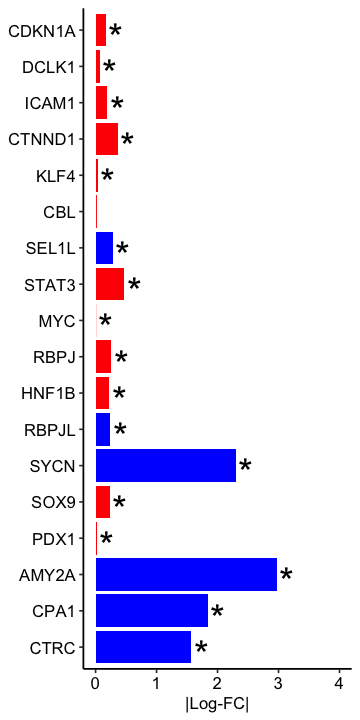

In [22]:
marker_table <- fread("../data/progenitor_marker_table.tsv")[,!c("Stainings\ and\ References")]
set(marker_table,NULL,"Acinar -> Progenitor",paste(marker_table$`Acinar cell`, marker_table$`Embryonic progenitor`,sep=" to "))
set(marker_table,NULL,"Ductal -> Progenitor",paste(marker_table$`Duct cell`, marker_table$`Embryonic progenitor`,sep=" to "))
marker_table <- marker_table[,!c("Acinar cell","Duct cell","Embryonic progenitor","")]
marker_genes <- marker_table$Marker

new_markers <- c("STAT3","SEL1L","CBL","KLF4","CTNND1","LKB1","ICAM1","DCLK1","CDKN1A") #Markers of ADM
marker_genes <- c(marker_genes,new_markers) %>% setdiff(.,c("KRT19","PARM1","GP2","PTF1A")) #These markers in Baldan et. al pertain to ductal cells and not acinar cells

sub_meta_data_dt <- meta_data_dt[cluster %in% c("Acinar cell"),.(cell.name,cluster)]
sub_meta_data_dt <- merge( sub_meta_data_dt, edge_info_all$edge_center_dt[,.(cell.name,cell_category)], by="cell.name")
sub_meta_data_dt[cluster == "Acinar cell",cell_type:=fifelse(cell_category == "edge","Edge Acinar","Non-Edge Acinar")]
sub_meta_data <- as.data.frame(sub_meta_data_dt[,list(cell_type)])
rownames(sub_meta_data) <- sub_meta_data_dt$cell.name
subset_seurat_obj <- subset( seurat_obj,
                            cells=sub_meta_data_dt$cell.name,
                            features=marker_genes)
subset_seurat_obj <- AddMetaData( subset_seurat_obj, sub_meta_data ) %>% SetIdent( ., value="cell_type")

#Setting min.pct = 0 and logfc.threshold = -Inf is the only way to force Seurat to compute LogFC values
#of all genes.
prog_markers_df <- FindMarkers( subset_seurat_obj, ident.1="Edge Acinar", 
min.pct = 0, logfc.threshold=-Inf) %>% 
tibble::rownames_to_column("gene") %>%  mutate(significant=ifelse(p_val < 0.01,TRUE,FALSE),
                                              regulation_type=ifelse(avg_logFC < 0,"Down","Up")) %>%
mutate(display_gene=ifelse(significant,paste0("*",gene),gene)) %>% merge( marker_table[,.(Marker,`Acinar -> Progenitor`)], by.x="gene", by.y="Marker",all.x=T)
for (gene in marker_genes) {
    if (!gene %in% marker_table$Marker){
        marker_table <- rbind( marker_table, list(gene,"- to +","- to +"))
    }
}

options(repr.plot.height=6,repr.plot.width=3)
prog_markers_df$gene <- factor(prog_markers_df$gene, marker_genes )
p <- ggplot( prog_markers_df ) + geom_bar(aes(x=gene,y=abs(avg_logFC),fill=regulation_type),
                                     stat="identity") + coord_flip() +
 geom_text(data = prog_markers_df %>% dplyr::filter(significant), aes(x=gene,y=abs(avg_logFC)),label="*", 
           hjust=-0.2, vjust=0.75, size=8) +
theme_pubr(base_size=10) + theme(legend.position="none",axis.text.x=element_text(size=10)) + 
scale_fill_manual(values=c("Down"="blue","Up"="red")) + xlab(NULL) + ylab("|Log-FC|") + ylim(0,4)
print(p)
ggsave("Fig2-markers.svg",p,width=3,height=6.5)
rm(subset_seurat_obj)

In [293]:
if (!file.exists(file.path(base_path,"progenitor_annotation.tsv"))) {
    progenitory_seurat_obj <- process_progenitor_data()
    
    #These markers are derived from 
    marker_lists <- list("Bipotent"=c("NKX6-1","SOX9"),#Cluster 5,8 shows high bipotent signature. But since 5 is also high for multipotency, cluster 7 is the sole bipotent cluster.
                         "Multipotent"=c("SOX9","PTF1A","PDX1","NKX6-1")) #Clusters 5 shows high multipotent.
    
    dt_list <- list()
    for (cell_type in names(marker_lists)) {
        markers <- marker_lists[[cell_type]]
        marker_dt <- data.table( FetchData( progenitor_seurat_obj, 
                                           vars=c(markers,"seurat_clusters") ) )
        cluster_scores_dt <- marker_dt[,marker_mean:=lapply(.SD,mean),by=seurat_clusters][order(-marker_mean),.(seurat_clusters,marker_mean)] %>% unique
        dt_list[[cell_type]] <- cluster_scores_dt
    }
} else {
    progenitor_meta_data_dt <- fread(file.path(base_path,"progenitor_annotation.tsv"))
    progenitor_seurat_obj <- create_full_seurat_object( progenitor_count_mat, progenitor_meta_data_dt )
    #Cluster 5 contains Sox9+,PTF1a+,Pdx1+,Nkx6-1+ cells (multipotent)
    multipotent_cells <- progenitor_meta_data_dt[seurat_clusters == 5,cell.name]
    #Cluster 8 contains Sox9+,PTF1a+,Pdx1+,Nkx6-1+ cells (multipotent)
    bipotent_cells <- progenitor_meta_data_dt[seurat_clusters == 8,cell.name]
}

progenitor_seurat_obj <- SetIdent( progenitor_seurat_obj, value="seurat_clusters" ) %>% 
subset(.,features=rownames(seurat_obj))
multipotent_markers_df <- FindMarkers( progenitor_seurat_obj, ident.1="5")
bipotent_markers_df <- FindMarkers( progenitor_seurat_obj, ident.1="8")
multipotent_genes <- multipotent_markers_df %>% tibble::rownames_to_column("gene") %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1) %>% pull(gene)
bipotent_genes <- bipotent_markers_df %>% tibble::rownames_to_column("gene") %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1) %>% pull(gene)

# fwrite(multipotent_markers_df %>% tibble::rownames_to_column("gene") %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1),
#        "multipotent_markers.tsv",sep="\t")
# fwrite(bipotent_markers_df %>% tibble::rownames_to_column("gene") %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1),
#        "bipotent_markers.tsv",sep="\t")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


ERROR: Error: 'filter' is defunct.
Use 'mast_filter' instead.
See help("Defunct")


### Figure S3B

Violin plots of multipotent and bipotent marker genes in each of the clusters in embryonic pancreas data.

In [ ]:
options(repr.plot.height=6,repr.plot.width=6)
plot_list <- VlnPlot( progenitor_seurat_obj, features=marker_lists[["Multipotent"]], 
        group.by="seurat_clusters",pt.size=0.1, combine=F )
plot_list <- lapply(plot_list,function(p){return(p+theme(legend.position="none",title=element_text(size=7)))})
p_markers <- ggarrange(plotlist=plot_list,nrow=2,ncol=2)
ggsave("progenitor_markers.svg",p,width=6,height=4)

### Figure S3A

In [ ]:
progenitor_seurat_obj <- NormalizeData(progenitor_seurat_obj) %>% ScaleData(.) %>% 
FindVariableFeatures(.,nfeatures = 2000) %>% RunPCA(.,dims=50) %>% RunUMAP(.,dims=1:50)

options(repr.plot.height=6,repr.plot.width=6)
p_umap <- DimPlot( progenitor_seurat_obj, group.by="seurat_clusters",label=T,label.size=4) + 
theme(legend.position="none")
ggsave("progenitors_umap.svg",p,width=6,height=6)

### Figure 2B

In [ ]:
gene_sets <- list("Bipotent"=bipotent_genes,"Multipotent"=multipotent_genes)
acinar_and_ductal_cells <- meta_data_dt %>% filter(cluster %in% c("Ductal cell type 1","Acinar cell")) %>% pull(cell.name)
acinar_mat <- seurat_obj[["RNA"]]@counts[,acinar_and_ductal_cells]
cells_rankings <- AUCell_buildRankings( acinar_mat, nCores=6, plotStats = F )
auc_obj <- AUCell_calcAUC( gene_sets, cells_rankings, nCores=6 )
auc_df <- getAUC(auc_obj) %>% t %>% as.data.frame %>% tibble::rownames_to_column("cell.name") %>% 
merge(.,edge_info_all$edge_center_dt[,.(cell.name,cell_category,normal_cell_type)],by="cell.name")

melted_auc_df <- auc_df %>% dplyr::select(-cell.name) %>% tidyr::pivot_longer(cols=c("Bipotent","Multipotent"),
                                                      values_to="AUC_score",names_to="Signature") %>% 
mutate( cell_category=ifelse(cell_category == "center","Non-Edge","Edge"))
melted_auc_df$cell_category <- factor(melted_auc_df$cell_category,levels=c("Edge","Non-Edge"))

options(repr.plot.width=4,repr.plot.height=3)
p <- ggviolin( melted_auc_df, x="cell_category",y="AUC_score",color="cell_category",
                                    size=0.2,linetype="cell_category",width=0.5,fill=NA ) + 
facet_wrap(vars(Signature,normal_cell_type),nrow=1) + theme_pubr(base_size=10) + 
xlab(NULL) + theme(panel.grid.major=element_line(color="gray",linetype="dotted"),legend.position="none") +
stat_compare_means(comparisons=list(c("Edge","Non-Edge")),
                   label.x=1.5,hjust=0.5,label="..p.signif..",
                   size=2,method.args=list("alternative"="g")) + ylim(0,0.5) + ylab("AUCell score")

ggsave("Fig2b.svg",p,width=3,height=1)

## Figure 2D

Below, we first compute an N x 3 matrix, where N = number of genes, and the columns represent the mean gene expression z-score of genes in acinar cells, normal ductal cells and malignant ductal cells. Note that the z-scoring is done after these three cell types are subsetted from the Seurat object. 

In [ ]:
subset_cells <- meta_data_dt %>% filter(cluster %in% c("Ductal cell type 1",
                                                       "Ductal cell type 2","Acinar cell")) %>% pull(cell.name)
subset_seurat_obj <- subset( seurat_obj, cells=subset_cells ) %>% ScaleData(.)

subset_meta_data_dt <- meta_data_dt[cell.name %in% subset_cells,.(cluster,cell.name)]
subset_meta_data_dt[,cell_ident:="Malignant"]
cluster_names <- list("edge Acinar cell"="Edge Acinar","center Acinar cell"="Non-Edge Acinar",
                     "edge Ductal cell type 1"="Outlier Ductal","center Ductal cell type 1"="Non-Outlier Ductal",
                     "Ductal cell type 2"="Malignant")
for (cell_type in c("Acinar cell","Ductal cell type 1")) {
    for (cell_category_ in c("edge","center")) {
        cells <- edge_info_all$edge_center_dt[normal_cell_type == cell_type & cell_category == cell_category_,cell.name]
        subset_meta_data_dt[cell.name %in% cells,cell_ident:=cluster_names[[paste(cell_category_,cell_type)]]]
    }
}
to_add_df <- as.data.frame(subset_meta_data_dt[,!c("cell.name")])
rownames(to_add_df) <- subset_meta_data_dt$cell.name
subset_seurat_obj <- AddMetaData(subset_seurat_obj,to_add_df) %>% SetIdent(.,value="cell_ident")

scaled_data <- subset_seurat_obj[["RNA"]]@scale.data
identities <- c("Edge Acinar","Non-Edge Acinar","Outlier Ductal","Non-Outlier Ductal","Malignant")
zscores_mat <- matrix(0,nrow=nrow(scaled_data),ncol=length(identities)+1,
                     dimnames=list(rownames(scaled_data),c(identities,"All Ductal")))
for (ident in identities) {
    zscores_mat[,ident] <- scaled_data[,WhichCells(subset_seurat_obj,ident=ident)] %>% rowMeans(.)
}
zscores_mat[,"All Ductal"] <- scaled_data[,subset_meta_data_dt[cluster == "Ductal cell type 1",cell.name]] %>% rowMeans(.)
rm(scaled_data)
rm(subset_seurat_obj)

In [ ]:
column_groups <- list("NEA-EA-M"=c("Non-Edge Acinar","Edge Acinar","Malignant"),
                     "NEA-EA-D1-M"=c("Non-Edge Acinar","Edge Acinar","All Ductal","Malignant"),
                     "NEA-EA-OD-M"=c("Non-Edge Acinar","Edge Acinar","Outlier Ductal","Malignant"),
                     "NEA-EA-NOD-M"=c("Non-Edge Acinar","Edge Acinar","Non-Outlier Ductal","Malignant"),
                     "NOD-OD-M"=c("Non-Outlier Ductal","Outlier Ductal","Malignant"))

path_mat_list <- list()
for (column_group in names(column_groups)) {
    path_mat <- zscores_mat[,column_groups[[column_group]]]
    path_mat_list[[column_group]] <- path_mat
}

enrichment_dt <- data.table()
threshold <- 0.2    #Threshold above which the difference in z-scores between two cell types is considered as significant.

#        in cluster | not in cluster
#   in set
#   not in set
for (column_group in names(path_mat_list)) {
    path_mat <- path_mat_list[[column_group]]
    differences <- t(apply(path_mat,1,diff))
    changing_genes_mask <- rowSums(differences > threshold) == ncol(differences)
    changing_genes <- rownames(path_mat)[changing_genes_mask]
    group_enrichment_dt <- compute_enrichment(changing_genes,rownames(seurat_obj))

    enrichment_dt <- rbind(enrichment_dt,group_enrichment_dt[,path:=column_group])
}
enrichment_dt[,p_adj:=p.adjust(p_value)]


## Figure S3C

In [ ]:
options(repr.plot.width=3,repr.plot.height=12)
pathway_mat <- tidyr::pivot_wider( enrichment_dt[,!c("p_value","q_value","odds_ratio")], names_from="path", values_from="p_adj" ) %>%
tibble::column_to_rownames("pathway") %>% as.matrix
pathway_mat <- pathway_mat[rowSums(pathway_mat < 0.1) >= 1,]
log_pathway_mat <- -log10(pathway_mat)
log_pathway_mat[log_pathway_mat < 1] <- NA
col_fun <- colorRamp2(c(0,40), c("blue","red"))
p_heatmap <- Heatmap(log_pathway_mat,cluster_columns=F,cluster_rows=F,col=col_fun,na_col="white",rect_gp = gpar(col="black"),
       column_names_gp=gpar(fontsize=8),row_names_gp=gpar(fontsize=8), width=unit(1,"in"), name="Log pvalue") #%>% as.ggplot


options(repr.plot.width=8,repr.plot.height=12)
figS2 <- grid.arrange(
    arrangeGrob(p_markers + labs(tag="A") + theme(plot.margin=unit(c(0,1,0,0),"cm"),plot.tag.position="topleft"),
                p_umap + labs(tag="B") + theme(plot.margin=unit(c(0,1,0,0),"cm"),plot.tag.position="topleft")),
    as.ggplot(p_heatmap) + labs(tag="C") + 
            theme(plot.tag.position="topleft",plot.margin=unit(c(0,0,0,-1.5),"cm")),
    heights=c(2,1),
    ncol=2
)
ggsave("Fig-S2.svg",figS2,width=8,height=12)

## Mechanisms of edge-ness

### Motif analysis

In [23]:
atac_peaks_dt <- fread(file.path(base_path,"acinar_atac_peaks.narrowPeak"))[,.(chr=V1,start=V2,end=V3)]

all_genes <- rownames(seurat_obj[["RNA"]]@data)
entrez_dt <- get_entrez_dt( all_genes )
entrez_ids <- entrez_dt$final_entrez_id

entrez_dt[,gene_type:="Expressed"]
cds_tx_dt <- select(TxDb.Hsapiens.UCSC.hg19.knownGene,columns=c("GENEID","TXNAME"),
               keytype=c("GENEID"), keys=entrez_ids ) %>% na.omit(.)
cds_tx_dt <- merge( cds_tx_dt, entrez_dt[,.(SYMBOL,final_entrez_id,gene_type)],
                   by.x="GENEID", by.y="final_entrez_id") %>% data.table(.)

atac_peaks_dt <- gene_assign( atac_peaks_dt, assign_type="overlap", dist_threshold = 10000 )
           

'select()' returned 1:many mapping between keys and columns



[1] "No alias found for AL627309.1"
[1] "No alias found for AP006222.2"
[1] "No alias found for RP11-206L10.3"
[1] "No alias found for RP11-206L10.2"
[1] "No alias found for RP11-206L10.9"
[1] "No alias found for RP11-54O7.3"
[1] "No alias found for RP11-54O7.17"
[1] "No alias found for RP11-465B22.8"
[1] "No alias found for RP4-758J18.2"
[1] "No alias found for RP4-758J18.13"
[1] "No alias found for RP4-758J18.10"
[1] "No alias found for AL645728.1"
[1] "No alias found for RP11-345P4.9"
[1] "No alias found for RP11-345P4.10"
[1] "No alias found for RP1-140A9.1"
[1] "No alias found for RP11-547D24.1"
[1] "No alias found for RP5-892K4.1"
[1] "No alias found for RP11-181G12.2"
[1] "No alias found for AL590822.1"
[1] "No alias found for RP11-181G12.5"
[1] "No alias found for RP3-395M20.12"
[1] "No alias found for RP3-395M20.9"
[1] "No alias found for RP11-168F9.2"
[1] "No alias found for RP11-46F15.2"
[1] "No alias found for RP1-120G22.11"
[1] "No alias found for RP1-202O8.3"
[1] "No alia

'select()' returned many:many mapping between keys and columns

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 6 out-of-bound ranges located on sequences
  chr4_ctg9_hap1, chr6_mann_hap4, chr9_gl000201_random,
  chr19_gl000209_random, chrUn_gl000223, and chrUn_gl000241. Note that
  ranges located on a sequence whose length is unknown (NA) or on a
  circular sequence are not considered out-of-bound (use seqlengths() and
  isCircular() to get the lengths and circularity flags of the underlying
  sequences). You can use trim() to trim these ranges. See
  ?`trim,GenomicRanges-method` for more information.”


### Peak-wise motif search

In [17]:
source("../src/motif_analysis.R")

subset_motifs <- function(all_tfs,frac_threshold=0.1) {
    tf_names <- c()
    for (motif in all_tfs) {
        if (str_detect(motif,"::")) {
            motif <- str_split(motif,"::") %>% unlist
        }

        reformatted <- str_replace_all(motif,"\\(..*\\)","") %>% str_trim %>% str_to_upper
        tf_names <- c(tf_names,reformatted)
    }
    tf_names <- unique(tf_names)

    seurat_obj <- SetIdent( seurat_obj, value="cluster")
    acinar_seurat_obj <- subset( seurat_obj, idents="Acinar cell")
    tfs_present <- tf_names[tf_names %in% rownames(acinar_seurat_obj)]
    frac_expressed <- rowMeans(acinar_seurat_obj[["RNA"]][tfs_present,] > 0)
    tfs_present[frac_expressed >= frac_threshold]
    rm(acinar_seurat_obj)
    
    motifs_to_use <- list()
    for (tf in tfs_present) {
        motifs <- str_detect(all_tfs,tf)    
        motifs_to_use <- c(motifs_to_use,all_tfs[motifs])
    }
    motifs_to_use <- unique(motifs_to_use)
    return(motifs_to_use)
}

In [24]:
motifs_to_use <- subset_motifs(names(merged_pwm_list))
promoter_atac_peaks_dt <- atac_peaks_dt[!is.na(SYMBOL),c("chr","start","end","SYMBOL","gene_type")] %>% unique#gene_assign( atac_peaks_dt, assign_type="overlap", dist_threshold = 10000 )
peaks_not_near_promoter_dt <- atac_peaks_dt[is.na(SYMBOL),c("chr","start","end","SYMBOL","gene_type")]
peaks_not_near_promoter_dt[,SYMBOL:=paste("seq",1:nrow(peaks_not_near_promoter_dt),sep="_")]

promoter_atac_granges <- makeGRangesFromDataFrame( promoter_atac_peaks_dt, keep.extra.columns=T ) %>% resize(.,width=100,fix="center")
atac_not_near_promoter_granges <- makeGRangesFromDataFrame( peaks_not_near_promoter_dt, keep.extra.columns=T ) %>% resize(.,width=100,fix="center")

pwm_list <- list()
for (motif in motifs_to_use) {
    pwm_list[[motif]] <- merged_pwm_list[[motif]]
}
edge_with_non_edge_list <- pwm_scan( pwm_list, 
                               foreground_granges_obj = promoter_atac_granges, 
                               background_granges_obj = atac_not_near_promoter_granges,
                               motif_p_value_thresh = 1e-5 )

enrichment_dt <- edge_with_non_edge_list$enrichment_dt %>% na.omit
tfs <- unique(enrichment_dt$tf)
foreground_dt <- edge_with_non_edge_list$fg_matches_dt
foreground_dt[,`:=`(gene_type=promoter_atac_peaks_dt$gene_type,SYMBOL=promoter_atac_peaks_dt$SYMBOL)]

idx <- 1

motif_gene_sets <- list()
for (tf_ in tfs) {
    print(idx)
    flush.console()
    tf_dt <- foreground_dt[get(tf_) == 1,c(tf_,"gene_type","SYMBOL"),with=F] %>% unique(.)
    motif_gene_sets[[tf_]] <- unique(tf_dt$SYMBOL)

   idx <- idx+1
}
enr_tfs <- enrichment_dt[q_value < 0.1,][order(num_fg),tf]

[1] "1/589"
[1] "2/589"
[1] "3/589"
[1] "4/589"
[1] "5/589"
[1] "6/589"
[1] "7/589"
[1] "8/589"
[1] "9/589"
[1] "10/589"
[1] "11/589"
[1] "12/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95df33a5' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9604bd795' has size 0. Returning a NULL data.table.”


[1] "13/589"
[1] "14/589"
[1] "15/589"
[1] "16/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b96a3ff95b' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92470c58' has size 0. Returning a NULL data.table.”


[1] "17/589"
[1] "18/589"
[1] "19/589"
[1] "20/589"
[1] "21/589"
[1] "22/589"
[1] "23/589"
[1] "24/589"
[1] "25/589"
[1] "26/589"
[1] "27/589"
[1] "28/589"
[1] "29/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97ae14404' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97cb1d72e' has size 0. Returning a NULL data.table.”


[1] "30/589"
[1] "31/589"
[1] "32/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9792cdf7f' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b934b4b133' has size 0. Returning a NULL data.table.”


[1] "33/589"
[1] "34/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9377bdb3e' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97c548788' has size 0. Returning a NULL data.table.”


[1] "35/589"
[1] "36/589"
[1] "37/589"
[1] "38/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91b65debe' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97a2523e6' has size 0. Returning a NULL data.table.”


[1] "39/589"
[1] "40/589"
[1] "41/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b923bad6e0' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b942f613ff' has size 0. Returning a NULL data.table.”


[1] "42/589"
[1] "43/589"
[1] "44/589"
[1] "45/589"
[1] "46/589"
[1] "47/589"
[1] "48/589"
[1] "49/589"
[1] "50/589"
[1] "51/589"
[1] "52/589"
[1] "53/589"
[1] "54/589"
[1] "55/589"
[1] "56/589"
[1] "57/589"
[1] "58/589"
[1] "59/589"
[1] "60/589"
[1] "61/589"
[1] "62/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92d58acbc' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95d0940be' has size 0. Returning a NULL data.table.”


[1] "63/589"
[1] "64/589"
[1] "65/589"
[1] "66/589"
[1] "67/589"
[1] "68/589"
[1] "69/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95dc87b80' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9474d1798' has size 0. Returning a NULL data.table.”


[1] "70/589"
[1] "71/589"
[1] "72/589"
[1] "73/589"
[1] "74/589"
[1] "75/589"
[1] "76/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b946b7c0f1' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92c829088' has size 0. Returning a NULL data.table.”


[1] "77/589"
[1] "78/589"
[1] "79/589"
[1] "80/589"
[1] "81/589"
[1] "82/589"
[1] "83/589"
[1] "84/589"
[1] "85/589"
[1] "86/589"
[1] "87/589"
[1] "88/589"
[1] "89/589"
[1] "90/589"
[1] "91/589"
[1] "92/589"
[1] "93/589"
[1] "94/589"
[1] "95/589"
[1] "96/589"
[1] "97/589"
[1] "98/589"
[1] "99/589"
[1] "100/589"
[1] "101/589"
[1] "102/589"
[1] "103/589"
[1] "104/589"
[1] "105/589"
[1] "106/589"
[1] "107/589"
[1] "108/589"
[1] "109/589"
[1] "110/589"
[1] "111/589"
[1] "112/589"
[1] "113/589"
[1] "114/589"
[1] "115/589"
[1] "116/589"
[1] "117/589"
[1] "118/589"
[1] "119/589"
[1] "120/589"
[1] "121/589"
[1] "122/589"
[1] "123/589"
[1] "124/589"
[1] "125/589"
[1] "126/589"
[1] "127/589"
[1] "128/589"
[1] "129/589"
[1] "130/589"
[1] "131/589"
[1] "132/589"
[1] "133/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94a593d41' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93e66bc45' has size 0. Returning a NULL data.table.”


[1] "134/589"
[1] "135/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9672040fe' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9b1644c0' has size 0. Returning a NULL data.table.”


[1] "136/589"
[1] "137/589"
[1] "138/589"
[1] "139/589"
[1] "140/589"
[1] "141/589"
[1] "142/589"
[1] "143/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93a97ad01' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9156120df' has size 0. Returning a NULL data.table.”


[1] "144/589"
[1] "145/589"
[1] "146/589"
[1] "147/589"
[1] "148/589"
[1] "149/589"
[1] "150/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94033afa2' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91bb636eb' has size 0. Returning a NULL data.table.”


[1] "151/589"
[1] "152/589"
[1] "153/589"
[1] "154/589"
[1] "155/589"
[1] "156/589"
[1] "157/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92688c4b9' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b949b9bc23' has size 0. Returning a NULL data.table.”


[1] "158/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b915b83ad8' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b96962a2d1' has size 0. Returning a NULL data.table.”


[1] "159/589"
[1] "160/589"
[1] "161/589"
[1] "162/589"
[1] "163/589"
[1] "164/589"
[1] "165/589"
[1] "166/589"
[1] "167/589"
[1] "168/589"
[1] "169/589"
[1] "170/589"
[1] "171/589"
[1] "172/589"
[1] "173/589"
[1] "174/589"
[1] "175/589"
[1] "176/589"
[1] "177/589"
[1] "178/589"
[1] "179/589"
[1] "180/589"
[1] "181/589"
[1] "182/589"
[1] "183/589"
[1] "184/589"
[1] "185/589"
[1] "186/589"
[1] "187/589"
[1] "188/589"
[1] "189/589"
[1] "190/589"
[1] "191/589"
[1] "192/589"
[1] "193/589"
[1] "194/589"
[1] "195/589"
[1] "196/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b977a7febc' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9ce1c185' has size 0. Returning a NULL data.table.”


[1] "197/589"
[1] "198/589"
[1] "199/589"
[1] "200/589"
[1] "201/589"
[1] "202/589"
[1] "203/589"
[1] "204/589"
[1] "205/589"
[1] "206/589"
[1] "207/589"
[1] "208/589"
[1] "209/589"
[1] "210/589"
[1] "211/589"
[1] "212/589"
[1] "213/589"
[1] "214/589"
[1] "215/589"
[1] "216/589"
[1] "217/589"
[1] "218/589"
[1] "219/589"
[1] "220/589"
[1] "221/589"
[1] "222/589"
[1] "223/589"
[1] "224/589"
[1] "225/589"
[1] "226/589"
[1] "227/589"
[1] "228/589"
[1] "229/589"
[1] "230/589"
[1] "231/589"
[1] "232/589"
[1] "233/589"
[1] "234/589"
[1] "235/589"
[1] "236/589"
[1] "237/589"
[1] "238/589"
[1] "239/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94b32cc96' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93c8fd909' has size 0. Returning a NULL data.table.”


[1] "240/589"
[1] "241/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9383f51db' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b978956be3' has size 0. Returning a NULL data.table.”


[1] "242/589"
[1] "243/589"
[1] "244/589"
[1] "245/589"
[1] "246/589"
[1] "247/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b934a3e09f' has size 0. Returning a NULL data.table.”


[1] "248/589"
[1] "249/589"
[1] "250/589"
[1] "251/589"
[1] "252/589"
[1] "253/589"
[1] "254/589"
[1] "255/589"
[1] "256/589"
[1] "257/589"
[1] "258/589"
[1] "259/589"
[1] "260/589"
[1] "261/589"
[1] "262/589"
[1] "263/589"
[1] "264/589"
[1] "265/589"
[1] "266/589"
[1] "267/589"
[1] "268/589"
[1] "269/589"
[1] "270/589"
[1] "271/589"
[1] "272/589"
[1] "273/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9232586e2' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b932cff839' has size 0. Returning a NULL data.table.”


[1] "274/589"
[1] "275/589"
[1] "276/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b919711050' has size 0. Returning a NULL data.table.”


[1] "277/589"
[1] "278/589"
[1] "279/589"
[1] "280/589"
[1] "281/589"
[1] "282/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92a8060b5' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93984489e' has size 0. Returning a NULL data.table.”


[1] "283/589"
[1] "284/589"
[1] "285/589"
[1] "286/589"
[1] "287/589"
[1] "288/589"
[1] "289/589"
[1] "290/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93470db0a' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9396c9b67' has size 0. Returning a NULL data.table.”


[1] "291/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94832d220' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91ff82374' has size 0. Returning a NULL data.table.”


[1] "292/589"
[1] "293/589"
[1] "294/589"
[1] "295/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9184c49bc' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95767b920' has size 0. Returning a NULL data.table.”


[1] "296/589"
[1] "297/589"
[1] "298/589"
[1] "299/589"
[1] "300/589"
[1] "301/589"
[1] "302/589"
[1] "303/589"
[1] "304/589"
[1] "305/589"
[1] "306/589"
[1] "307/589"
[1] "308/589"
[1] "309/589"
[1] "310/589"
[1] "311/589"
[1] "312/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b927fda986' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b966a81d16' has size 0. Returning a NULL data.table.”


[1] "313/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9162ab61d' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b944cb273d' has size 0. Returning a NULL data.table.”


[1] "314/589"
[1] "315/589"
[1] "316/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97fc536b' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91402906a' has size 0. Returning a NULL data.table.”


[1] "317/589"
[1] "318/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9781c48b5' has size 0. Returning a NULL data.table.”


[1] "319/589"
[1] "320/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9299ef33f' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b96795033d' has size 0. Returning a NULL data.table.”


[1] "321/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94220dad1' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91b09ab12' has size 0. Returning a NULL data.table.”


[1] "322/589"
[1] "323/589"
[1] "324/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b948685cbf' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b933fad827' has size 0. Returning a NULL data.table.”


[1] "325/589"
[1] "326/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9389114c4' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b977f26c0d' has size 0. Returning a NULL data.table.”


[1] "327/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91445fa5f' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92449db2f' has size 0. Returning a NULL data.table.”


[1] "328/589"
[1] "329/589"
[1] "330/589"
[1] "331/589"
[1] "332/589"
[1] "333/589"
[1] "334/589"
[1] "335/589"
[1] "336/589"
[1] "337/589"
[1] "338/589"
[1] "339/589"
[1] "340/589"
[1] "341/589"
[1] "342/589"
[1] "343/589"
[1] "344/589"
[1] "345/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b949adb94c' has size 0. Returning a NULL data.table.”


[1] "346/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95a8fcd03' has size 0. Returning a NULL data.table.”


[1] "347/589"
[1] "348/589"
[1] "349/589"
[1] "350/589"
[1] "351/589"
[1] "352/589"
[1] "353/589"
[1] "354/589"
[1] "355/589"
[1] "356/589"
[1] "357/589"
[1] "358/589"
[1] "359/589"
[1] "360/589"
[1] "361/589"
[1] "362/589"
[1] "363/589"
[1] "364/589"
[1] "365/589"
[1] "366/589"
[1] "367/589"
[1] "368/589"
[1] "369/589"
[1] "370/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9315e540d' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9e467c8b' has size 0. Returning a NULL data.table.”


[1] "371/589"
[1] "372/589"
[1] "373/589"
[1] "374/589"
[1] "375/589"
[1] "376/589"
[1] "377/589"
[1] "378/589"
[1] "379/589"
[1] "380/589"
[1] "381/589"
[1] "382/589"
[1] "383/589"
[1] "384/589"
[1] "385/589"
[1] "386/589"
[1] "387/589"
[1] "388/589"
[1] "389/589"
[1] "390/589"
[1] "391/589"
[1] "392/589"
[1] "393/589"
[1] "394/589"
[1] "395/589"
[1] "396/589"
[1] "397/589"
[1] "398/589"
[1] "399/589"
[1] "400/589"
[1] "401/589"
[1] "402/589"
[1] "403/589"
[1] "404/589"
[1] "405/589"
[1] "406/589"
[1] "407/589"
[1] "408/589"
[1] "409/589"
[1] "410/589"
[1] "411/589"
[1] "412/589"
[1] "413/589"
[1] "414/589"
[1] "415/589"
[1] "416/589"
[1] "417/589"
[1] "418/589"
[1] "419/589"
[1] "420/589"
[1] "421/589"
[1] "422/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b979cbf1f' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92c50215a' has size 0. Returning a NULL data.table.”


[1] "423/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b968000049' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b920850e61' has size 0. Returning a NULL data.table.”


[1] "424/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b937d7e3c4' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9506fb8f6' has size 0. Returning a NULL data.table.”


[1] "425/589"
[1] "426/589"
[1] "427/589"
[1] "428/589"
[1] "429/589"
[1] "430/589"
[1] "431/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b914433d5d' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93ec7368c' has size 0. Returning a NULL data.table.”


[1] "432/589"
[1] "433/589"
[1] "434/589"
[1] "435/589"
[1] "436/589"
[1] "437/589"
[1] "438/589"
[1] "439/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b959e9d9b9' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b969649694' has size 0. Returning a NULL data.table.”


[1] "440/589"
[1] "441/589"
[1] "442/589"
[1] "443/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97186d536' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9504c002b' has size 0. Returning a NULL data.table.”


[1] "444/589"
[1] "445/589"
[1] "446/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93efdc008' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95b1f0a1b' has size 0. Returning a NULL data.table.”


[1] "447/589"
[1] "448/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97e615f27' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9132d2c08' has size 0. Returning a NULL data.table.”


[1] "449/589"
[1] "450/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9780b2bde' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9595318c1' has size 0. Returning a NULL data.table.”


[1] "451/589"
[1] "452/589"
[1] "453/589"
[1] "454/589"
[1] "455/589"
[1] "456/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9752bd558' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b954d4ee6d' has size 0. Returning a NULL data.table.”


[1] "457/589"
[1] "458/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b912c33fd' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9185da8cb' has size 0. Returning a NULL data.table.”


[1] "459/589"
[1] "460/589"
[1] "461/589"
[1] "462/589"
[1] "463/589"
[1] "464/589"
[1] "465/589"
[1] "466/589"
[1] "467/589"
[1] "468/589"
[1] "469/589"
[1] "470/589"
[1] "471/589"
[1] "472/589"
[1] "473/589"
[1] "474/589"
[1] "475/589"
[1] "476/589"
[1] "477/589"
[1] "478/589"
[1] "479/589"
[1] "480/589"
[1] "481/589"
[1] "482/589"
[1] "483/589"
[1] "484/589"
[1] "485/589"
[1] "486/589"
[1] "487/589"
[1] "488/589"
[1] "489/589"
[1] "490/589"
[1] "491/589"
[1] "492/589"
[1] "493/589"
[1] "494/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94dc23462' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93d2ac639' has size 0. Returning a NULL data.table.”


[1] "495/589"
[1] "496/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93d919e88' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97155a258' has size 0. Returning a NULL data.table.”


[1] "497/589"
[1] "498/589"
[1] "499/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9678dc06d' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b968e3357d' has size 0. Returning a NULL data.table.”


[1] "500/589"
[1] "501/589"
[1] "502/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9767f07da' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93c18ab30' has size 0. Returning a NULL data.table.”


[1] "503/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b94f20bae6' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93c226147' has size 0. Returning a NULL data.table.”


[1] "504/589"
[1] "505/589"
[1] "506/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b949662c14' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93b5318e1' has size 0. Returning a NULL data.table.”


[1] "507/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b95fbd4459' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97ee38677' has size 0. Returning a NULL data.table.”


[1] "508/589"
[1] "509/589"
[1] "510/589"
[1] "511/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9675b89f9' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92d469b69' has size 0. Returning a NULL data.table.”


[1] "512/589"
[1] "513/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93c0e7334' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9661bc389' has size 0. Returning a NULL data.table.”


[1] "514/589"
[1] "515/589"
[1] "516/589"
[1] "517/589"
[1] "518/589"
[1] "519/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b99cc70cd' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b976eaa1af' has size 0. Returning a NULL data.table.”


[1] "520/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9293f00b3' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b92ea02e2f' has size 0. Returning a NULL data.table.”


[1] "521/589"
[1] "522/589"
[1] "523/589"
[1] "524/589"
[1] "525/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b93e72b66' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b918f19388' has size 0. Returning a NULL data.table.”


[1] "526/589"
[1] "527/589"
[1] "528/589"
[1] "529/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9209cf981' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b9e523d0f' has size 0. Returning a NULL data.table.”


[1] "530/589"
[1] "531/589"
[1] "532/589"
[1] "533/589"
[1] "534/589"
[1] "535/589"
[1] "536/589"
[1] "537/589"
[1] "538/589"
[1] "539/589"
[1] "540/589"
[1] "541/589"
[1] "542/589"
[1] "543/589"
[1] "544/589"
[1] "545/589"
[1] "546/589"
[1] "547/589"
[1] "548/589"
[1] "549/589"
[1] "550/589"
[1] "551/589"
[1] "552/589"


Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b97ba0cba9' has size 0. Returning a NULL data.table.”
Warning message in fread(cmd = sarus_command):
“File '/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmpaOfmns/file67b91929c6ad' has size 0. Returning a NULL data.table.”


[1] "553/589"
[1] "554/589"
[1] "555/589"
[1] "556/589"
[1] "557/589"
[1] "558/589"
[1] "559/589"
[1] "560/589"
[1] "561/589"
[1] "562/589"
[1] "563/589"
[1] "564/589"
[1] "565/589"
[1] "566/589"
[1] "567/589"
[1] "568/589"
[1] "569/589"
[1] "570/589"
[1] "571/589"
[1] "572/589"
[1] "573/589"
[1] "574/589"
[1] "575/589"
[1] "576/589"
[1] "577/589"
[1] "578/589"
[1] "579/589"
[1] "580/589"
[1] "581/589"
[1] "582/589"
[1] "583/589"
[1] "584/589"
[1] "585/589"
[1] "586/589"
[1] "587/589"
[1] "588/589"
[1] "589/589"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



   min     1%     5%    10%    50%   100% 
 250.0  358.8  522.0  631.0 1317.0 7675.0 


Using 6 cores.

Warning message in .AUCell_calcAUC(geneSets = geneSets, rankings = rankings, nCores = nCores, :
“Ignoring the following empty sets: POU6F1, LHX6, PHOX2A, CUX1, CUX2”
Using 6 cores.



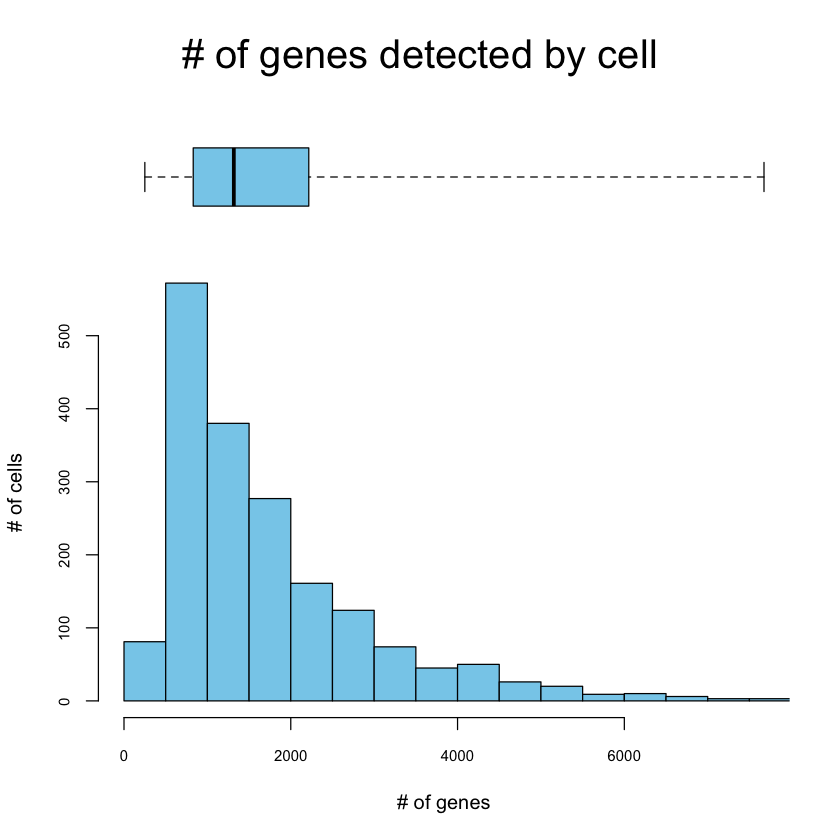

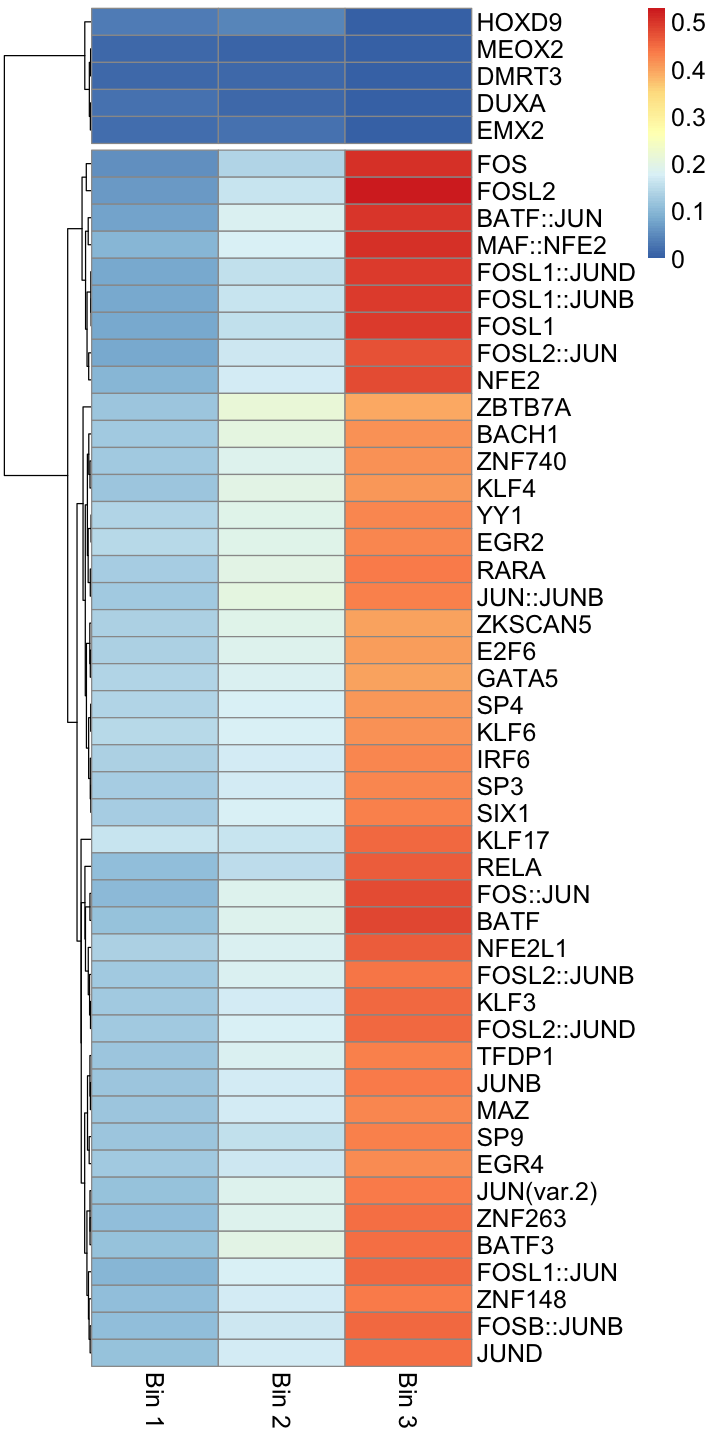

In [25]:
seurat_obj <- SetIdent(seurat_obj,value="cluster")
acinar_gene_exp_mat <- seurat_obj[["RNA"]]@counts[,WhichCells(seurat_obj,ident="Acinar cell")]
rankings <- AUCell_buildRankings( acinar_gene_exp_mat, nCores=6 )
rm(acinar_gene_exp_mat)
auc_obj <- AUCell_calcAUC( motif_gene_sets, rankings )
auc_mat <- getAUC(auc_obj)
auc_thresholds <- AUCell_exploreThresholds( auc_obj, plotHist=F, nCores=3 )
tfs <- names(auc_obj)
threshold_vec <- sapply(tfs,function(x){return(auc_thresholds[[x]]$aucThr$thresholds["Global_k1","threshold"]);})
binarized_auc_mat <- sapply(1:length(tfs),function(x){return(auc_mat[x,] > threshold_vec[x]);}) %>% t
rownames(binarized_auc_mat) <- tfs

num_bins <- 3
bin_column_names <- paste("Bin",1:num_bins)

acinar_edge_center_dt <- edge_info_all$edge_center_dt[normal_cell_type == "Acinar cell",]
acinar_edge_cells <- acinar_edge_center_dt[cell_category == "edge",cell.name]

distance_quantiles <- quantile(acinar_edge_center_dt$dist_from_normal_medoid, seq(0,1,by=1/num_bins))
num_quantiles <- length(distance_quantiles)
bin_cells_list <- list()


for (q_idx in 1:(num_quantiles-1)) {
    lower <- distance_quantiles[q_idx]
    upper <- distance_quantiles[q_idx+1]
    bin_cells_list[[q_idx]] <- acinar_edge_center_dt[dist_from_normal_medoid >= lower & 
                                                     dist_from_normal_medoid < upper,cell.name]
}

binned_auc_mat <- matrix(0,nrow=nrow(binarized_auc_mat),ncol=num_bins)
for (bin in 1:num_bins) {
    binned_auc_mat[,bin] <- rowMeans(binarized_auc_mat[,bin_cells_list[[bin]]])
}
rownames(binned_auc_mat) <- rownames(binarized_auc_mat)
colnames(binned_auc_mat) <- paste("Bin",1:num_bins)

gene_set_cv <- apply(binned_auc_mat,1,sd)/rowMeans(binned_auc_mat)
most_var_gene_sets <- names(sort(gene_set_cv,decreasing=T))[1:50]
options(repr.plot.width=6,repr.plot.height=12)
pheatmap(binned_auc_mat[c(most_var_gene_sets),],cluster_cols=F,fontsize=15,cutree_rows=2)

saveRDS(binned_auc_mat[c(most_var_gene_sets),],"binned_auc_mat_most_var_new.rds")
saveRDS(binned_auc_mat,"binned_auc_mat_new.rds")

writexl::write_xlsx( data.table( binned_auc_mat, keep.rownames=T) %>% setnames("rn","gene_name"),
                    "Table_S2.xlsx" )

## Figure 2C

Gene set activity changes from non-edge to edge cells

In [49]:
acinar_seurat_obj <- subset( seurat_obj, subset = cluster == "Acinar cell") %>% ScaleData(.,features=rownames(seurat_obj))
num_bins <- 3
bin_column_names <- paste("Bin",1:num_bins)

acinar_edge_center_dt <- edge_info_all$edge_center_dt[normal_cell_type == "Acinar cell",]

distance_quantiles <- quantile(acinar_edge_center_dt$dist_from_normal_medoid, seq(0,1,by=1/num_bins))
num_quantiles <- length(distance_quantiles)
gene_exp_mat <- matrix(0,nrow=length(rownames(acinar_seurat_obj)),ncol=num_bins,
                      dimnames=list(rownames(acinar_seurat_obj),1:num_bins))

for (q_idx in 1:(num_quantiles-1)) {
    lower <- distance_quantiles[q_idx]
    upper <- distance_quantiles[q_idx+1]
    cells <- acinar_edge_center_dt[dist_from_normal_medoid >= lower & 
                                                     dist_from_normal_medoid < upper,cell.name]
    gene_exp_mat[,q_idx] <- rowMeans(acinar_seurat_obj[["RNA"]]@scale.data[,cells])
}
inter_bin_diff_mat <- apply(gene_exp_mat,1,diff) %>% t
z_score_thresh <- 0.1

top_num <- ceiling( 0.2 * length(rownames(seurat_obj )))
foreground_genes <- names(which(inter_bin_diff_mat[,1] > z_score_thresh & inter_bin_diff_mat[,2] > z_score_thresh))

#Ordinarily, we would select genes which are expressed in at least 1% of cells. However, there is such a 
#large change in gene expression from the non-edge to edge state that this filter effectively removes most of the
#genes expressed in Bin 1.
background_genes <- names(which(rowSums(acinar_seurat_obj[["RNA"]]@counts) > 0))

enrichment_dt <- compute_enrichment(foreground_genes,background_genes)

mascaux_gene_sets <- c("MYC_TARGETS_V2","MYC_TARGETS_V1","MTORC1_SIGNALING","PI3K_AKT_MTOR_SIGNALING",
                      "E2F_TARGETS","MITOTIC_SPINDLE","INTERFERON_GAMMA_RESPONSE","ALLOGRAFT_REJECTION",
                      "G2M_CHECKPOINT","IL6_JAK_STAT_SIGNALING","TNFA_SIGNALING_VIA_NFKB","INFLAMMATORY_RESPONSE",
                      "IL2_STAT5_SIGNALING","ADIPOGENESIS","EPITHELIAL_MESENCHYMAL_TRANSITION","UV_RESPONSE_UP","UV_RESPONSE_DOWN",
                      "OXIDATIVE_PHOSPHORYLATION","FATTY_ACID_METABOLISM","HYPOXIA")
enrichment_dt[q_value < 0.1 & pathway %in% paste("HALLMARK",mascaux_gene_sets,sep="_"),]
rm(acinar_seurat_obj)

writexl::write_xlsx( enrichment_dt[q_value < 0.1,.(pathway,odds_ratio,p_value,q_value)], 
                    "TableS1.xlsx" )

Centering and scaling data matrix



pathway,p_value,odds_ratio,num_p_fg,num_p_bg,num_not_p_fg,num_not_p_bg,q_value
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
HALLMARK_TNFA_SIGNALING_VIA_NFKB,4.781332e-11,2.839284,71,124,3202,15880,2.773172e-09
HALLMARK_HYPOXIA,1.312225e-09,2.704481,65,119,3208,15885,7.348460e-08
HALLMARK_G2M_CHECKPOINT,3.606909e-03,1.627380,47,142,3226,15862,8.295890e-02
HALLMARK_ADIPOGENESIS,4.839384e-08,2.452499,62,125,3211,15879,2.371298e-06
HALLMARK_INTERFERON_GAMMA_RESPONSE,2.152267e-09,2.590570,68,130,3205,15874,1.162224e-07
HALLMARK_PI3K_AKT_MTOR_SIGNALING,8.948537e-04,2.105654,30,70,3243,15934,2.416105e-02
HALLMARK_MTORC1_SIGNALING,2.065359e-07,2.306894,63,135,3210,15869,9.500650e-06
HALLMARK_E2F_TARGETS,4.811920e-04,1.778023,52,144,3221,15860,1.395457e-02
HALLMARK_MYC_TARGETS_V1,1.056559e-45,8.221177,122,75,3151,15929,6.761976e-44


## Regression to find genes increasing/decreasing in expression with age in acinar cells in source PDAC data

In [16]:
original_age_dt <- data.table( sample=c(paste0("T",1:24),paste0("N",1:11)),
                              age=c(64,52,58,72,65,64,70,66,36,61,51,54,58,67,54,56,71,
                                    68,59,59,59,67,54,44,64,55,50,53,52,31,42,41,34,65,30),
                             gender=c("M","M","F","F","F","M","M","F","M","M","M","M","F","F","F","F","F","F","F","M","M","F","M","F", 
                                      "F","M","M","M","F","F","F","M","M","F","F"))

original_age_dt <- merge( edge_info_all$edge_center_dt[normal_cell_type == "Acinar cell",.(cell.name,cell_type=cell_category)],
                 meta_data_dt[,.(cell.name,sample)], by="cell.name" ) %>% merge(.,original_age_dt,by="sample")

original_acinar_obj <- subset( seurat_obj, subset=cluster == "Acinar cell") %>%
 ScaleData %>% CellCycleScoring(.,s.features = s.genes,g2m.features=g2m.genes)
source("../src/process_pdac.R")
original_age_dt <- merge( original_age_dt, 
                         tibble::rownames_to_column(original_acinar_obj@meta.data,"cell.name" ),
                         by="cell.name" )
output_df <- gene_exp_regression( original_acinar_obj[["RNA"]]@scale.data,
                                 original_age_dt %>% tibble::column_to_rownames("cell.name"),
                                 c("nFeature_RNA","S.Score","G2M.Score","age","gender"),c("age"))

age_increasing_genes <- output_df[age_q_value < 0.1 & age_coef > 0,gene]
num_cells_thresh <- ceiling(0.01 * length(Cells(original_acinar_obj)))
non_zero_expressed_genes <- names(which(rowSums(original_acinar_obj[["RNA"]]@counts > 0) > num_cells_thresh))

all_edge_acinar_genes <- lr_markers_df_list[["Acinar cell"]] %>% dplyr::filter(avg_logFC > 0 & p_val_adj < 0.1) %>% pull(gene)
dt <- compute_enrichment( age_increasing_genes, non_zero_expressed_genes, 
                         pathways = list("Edge"=all_edge_acinar_genes))
                                        #"Multipotent"=multipotent_genes,
                                        #"Bipotent"=bipotent_genes))
print(dt)

all_edge_acinar_genes <- setdiff(all_edge_acinar_genes,age_increasing_genes)

fwrite(output_df[age_q_value < 0.1 & age_coef > 0,],"acinar_increasing_with_age_sex_regressed.tsv",sep="\t")
fwrite(output_df[age_q_value < 0.1 & age_coef < 0,],"acinar_decreasing_with_age_sex_regressed.tsv",sep="\t")
fwrite( lr_markers_df_list[["Acinar cell"]] %>% dplyr::filter(p_val_adj < 0.1) %>% 
mutate(gene_type=ifelse(avg_logFC > 0,"Upregulated","Downregulated")) %>% arrange(-avg_logFC),
      "acinar_edge_markers.tsv", sep="\t")

Centering and scaling data matrix

Warning message:
“The following features are not present in the object: UHRF1, MLF1IP, CASP8AP2, not searching for symbol synonyms”


   pathway     p_value odds_ratio num_p_fg num_p_bg num_not_p_fg num_not_p_bg
1:    Edge 0.001014634   4.410755        8      538           42        12461
       q_value
1: 0.001014634


## Edge cells in other datasets

### GSE81547

In [3]:
detach("package:monocle3") #Monocle3 breaks the pData call from GEOquery. This hack circumvents the issue.
aging_obj <- process_GSE81547()
aging_meta_data_dt <- data.table( aging_obj@meta.data, keep.rownames=T ) %>% setnames(.,"rn","cell.name")
library(monocle3)

[1] "../data/GSE81547/GSE81547_mat.tsv.gz"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Found 1 file(s)

GSE81547_series_matrix.txt.gz

Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.


Attaching package: ‘monocle3’


The following objects are masked from ‘package:monocle’:

    plot_genes_in_pseudotime, plot_genes_violin,
    plot_pc_variance_explained


The following objects are masked from ‘package:Biobase’:

    exprs, fData, fData<-, pData, pData<-




#### Computing the edge cell fraction

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



   min     1%     5%    10%    50%   100% 
 470.0  722.0 1703.5 2008.0 3057.0 6399.0 


Using 6 cores.

Genes in the gene sets NOT available in the dataset: 
	edge: 	10 (2% of 538)



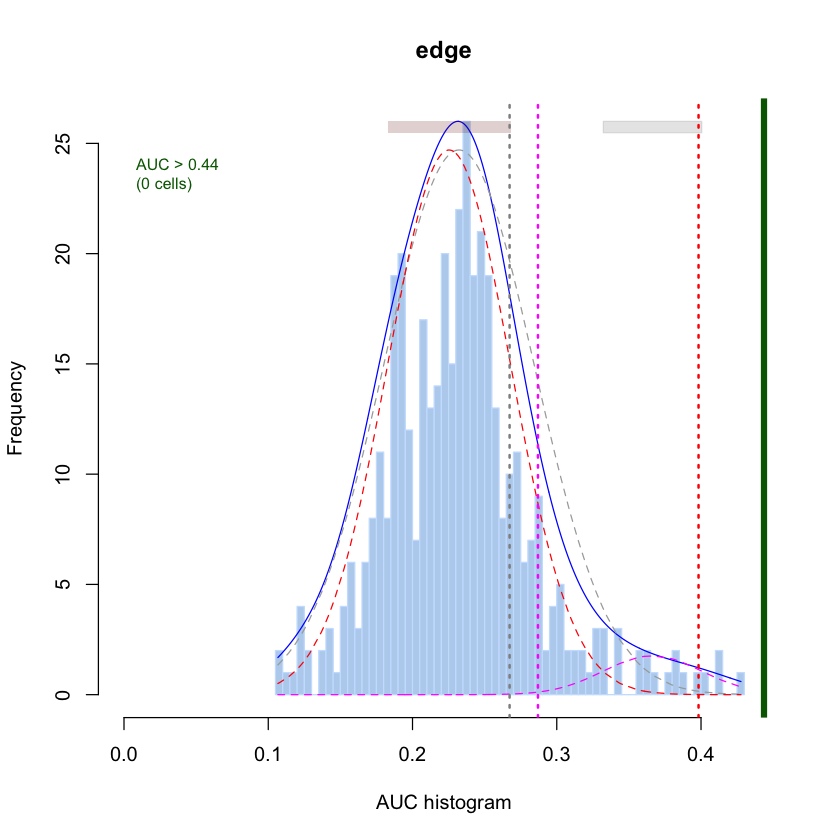

In [19]:
aging_obj <- SetIdent(aging_obj,value="cell_type")
aging_acinar_cells <- WhichCells(aging_obj,idents="acinar")
aging_acinar_count_mat <- aging_obj[["RNA"]]@counts[,aging_acinar_cells]
gene_set <- list("edge"=all_edge_acinar_genes)
source("../src/process_pdac.R")
aucell_info <- compute_gene_set_AUCell_scores(aging_acinar_count_mat,gene_set,aging_meta_data_dt)
efsun_aucell_dt <- aucell_info$aucell_dt
efsun_info_tbl <- compute_edge_frac( efsun_aucell_dt )

#### Figure 4A : Prepare ADM/dedifferentiation marker plot

In [23]:
sub_meta_data_dt <- aging_meta_data_dt[cell_type == "acinar",.(cell.name,cluster=cell_type,nFeature_RNA)]
sub_meta_data_dt <- merge( sub_meta_data_dt, 
                          efsun_aucell_dt, by="cell.name")

subset_seurat_obj <- subset( aging_obj,
                            cells=sub_meta_data_dt$cell.name ) %>%
CellCycleScoring(.,s.features=s.genes,g2m.features=g2m.genes) 

subset_seurat_obj <- AddMetaData( subset_seurat_obj, sub_meta_data_dt %>%dplyr::select(cell.name,age,nFeature_RNA,cell_type) %>%
                                tibble::column_to_rownames("cell.name")) %>% SetIdent( ., value="cell_type")
options(repr.plot.height=6,repr.plot.width=3)
efsun_markers_df <- FindMarkers(subset_seurat_obj,test.use="LR",ident.1="edge",
                                    latent.vars=c("S.Score","G2M.Score","nFeature_RNA"))
 
subset_seurat_obj <- subset_seurat_obj %>% subset(.,features=marker_genes)
prog_markers_df <- FindMarkers( subset_seurat_obj, ident.1="edge", min.pct = 0, logfc.threshold=-Inf) %>% 
tibble::rownames_to_column("gene") %>%  
mutate(significant=ifelse(p_val < 0.01,TRUE,FALSE),
                                               regulation_type=ifelse(avg_logFC < 0,"Down","Up")) %>%
mutate(display_gene=ifelse(significant,paste0("*",gene),gene)) %>% merge( marker_table[,.(Marker,`Acinar -> Progenitor`)], by.x="gene", by.y="Marker",all.x=T)
prog_markers_df$gene <- factor(prog_markers_df$gene, marker_genes )
p_efsun_markers <- ggplot( prog_markers_df ) + geom_bar(aes(x=gene,y=abs(avg_logFC),fill=regulation_type),
                                     stat="identity") + coord_flip() +
 geom_text(data = prog_markers_df %>% dplyr::filter(significant), aes(x=gene,y=abs(avg_logFC)),label="*", 
           hjust=0.0, vjust=0.75, size=8) +
theme_pubr(base_size=13.33) + theme(legend.position="none") + 
scale_fill_manual(values=c("Down"="blue","Up"="red")) + xlab(NULL) + ylab("|Log-FC|") + ylim(0,0.75)
rm(subset_seurat_obj)

### GSE85241

#### Computing the edge cell fraction

Warning message in fread(matrix_path):
“Detected 3072 column names but the data has 3073 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

PC_ 1 
Positive:  REST, ZFP36L1, IFITM3, MYH9, NOTCH2, SOX4, MYL12A, S100A11, RBPMS, MSN 
	   YAP1, LGALS3, PMEPA1, CLIC4, CAV2, TMSB10, TPM1, ANO6, TMSB4X, ANXA2P2 
	   LAMC1, PPIC, SPTBN1, ANXA2, AHNAK, RHOC, EPS8, CDC42EP1, LITAF, OSMR 
Negative:  CHGB, SCG3, VGF, SYT7, ABCC8, GAD2, MIR7-3HG, PLCXD3, ERO1LB, STMN2 
	   G6PC2, KIF5C, MLXIPL, STX1A, RGS4, CFC1, CRYBA2, PEG10, WNT4, KCNK16 
	   PRUNE2, FEV, PCP4, SST, ATP2A3, SYT13, FAM105A, RASD1, KCNK17, PCSK1 
PC_ 2 
Positive:  CD24, TACSTD2, ELF3, KIAA1522, KRT8

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3072
Number of edges: 155062

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8749
Number of communities: 12
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:51:59 UMAP embedding parameters a = 0.9922 b = 1.112

17:51:59 Read 3072 rows and found 50 numeric columns

17:51:59 Using Annoy for neighbor search, n_neighbors = 30

17:51:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:52:00 Writing NN index file to temp file /var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmprL6nnw/filee5f1215cd693

17:52:00 Searching Annoy index using 1 thread, search_k = 3000

17:52:01 Annoy recall = 100%

17:52:04 Commencing smooth kNN distance calibra

     min       1%       5%      10%      50%     100% 
 1903.00  2612.48  3572.50  4075.20  6291.00 10995.00 


Using 6 cores.

Genes in the gene sets NOT available in the dataset: 
	edge: 	8 (1% of 538)



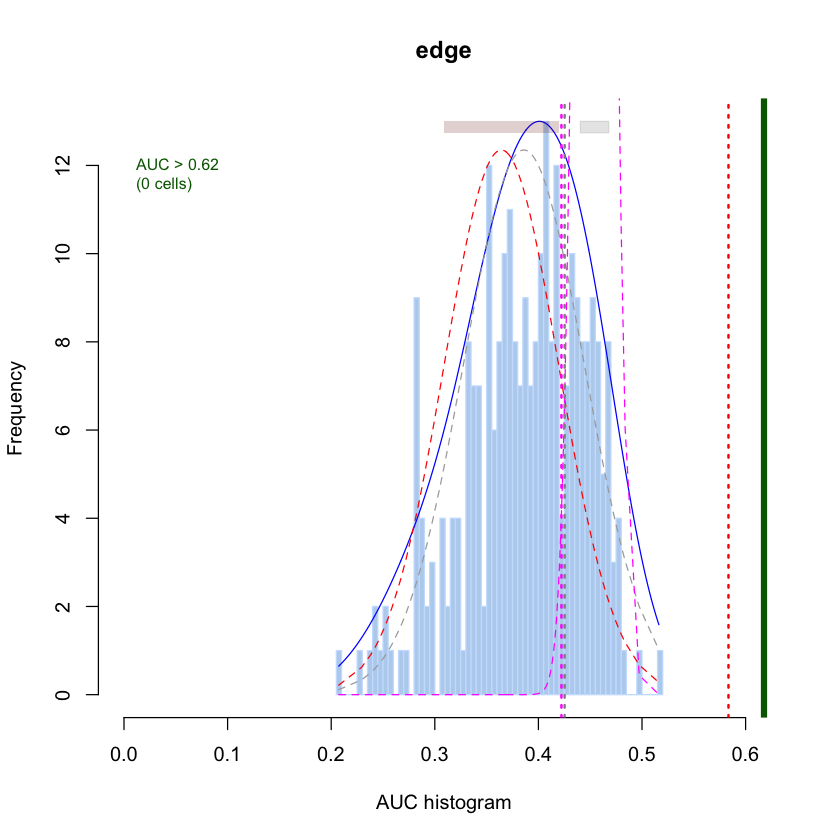

In [20]:
out <- process_GSE85241()
cel_seq_obj <- out$seurat_obj
cel_seq_meta_data_dt <- out$meta_data
vano_acinar_cells <- out$acinar_cells
rm(out)

source("../src/process_pdac.R")
acinar_count_mat <- cel_seq_obj[["RNA"]]@counts[,vano_acinar_cells]
gene_set <- list("edge"=all_edge_acinar_genes)
aucell_info <- compute_gene_set_AUCell_scores( cel_seq_obj[["RNA"]]@counts[,vano_acinar_cells],gene_set,
                                             cel_seq_meta_data_dt )
vano_aucell_dt <- aucell_info$aucell_dt
vano_info_tbl <- compute_edge_frac( vano_aucell_dt )

#### Figure 4A : Prepare ADM/dedifferentiation marker plot

In [24]:
sub_meta_data_dt <- cel_seq_meta_data_dt[cell.name %in% vano_acinar_cells,]#.(cell.name,cluster=cell_type)]
sub_meta_data_dt <- merge( sub_meta_data_dt, 
                          vano_aucell_dt[,.(cell.name,cell_type)], by="cell.name")

sub_meta_data <- as.data.frame(sub_meta_data_dt[,list(cell_type)])
rownames(sub_meta_data) <- sub_meta_data_dt$cell.name
subset_seurat_obj <- subset( cel_seq_obj,
                            cells=sub_meta_data_dt$cell.name ) %>% CellCycleScoring(.,
                                                                                   s.features=s.genes,
                                                                                   g2m.features=g2m.genes)
subset_seurat_obj <- AddMetaData( subset_seurat_obj, sub_meta_data ) %>% SetIdent( ., value="cell_type")
subset_seurat_obj <- subset( subset_seurat_obj, features=marker_genes)

prog_markers_df <- FindMarkers( subset_seurat_obj, ident.1="edge", min.pct = 0, logfc.threshold=-Inf) %>% 
tibble::rownames_to_column("gene") %>%  
mutate(significant=ifelse(p_val < 0.1,TRUE,FALSE),regulation_type=ifelse(avg_logFC < 0,"Down","Up")) %>%
mutate(display_gene=ifelse(significant,paste0("*",gene),gene)) %>% merge( marker_table[,.(Marker,`Acinar -> Progenitor`)], by.x="gene", by.y="Marker",all.x=T)
prog_markers_df$gene <- factor(prog_markers_df$gene, marker_genes )
p_vano_markers <- ggplot( prog_markers_df ) + geom_bar(aes(x=gene,y=abs(avg_logFC),fill=regulation_type),
                                     stat="identity") + coord_flip() +
 geom_text(data = prog_markers_df %>% dplyr::filter(significant), aes(x=gene,y=abs(avg_logFC)),label="*", 
           hjust=0.0, vjust=0.75, size=8) +
theme_pubr(base_size=13.33) + theme(legend.position="none") + 
scale_fill_manual(values=c("Down"="blue","Up"="red")) + xlab(NULL) + ylab("|Log-FC|") + ylim(0,2)

### Figure 4F

In [25]:
gse81547_acinar_obj <- subset( aging_obj, subset=cell_type == "acinar") 
gse81547_acinar_obj <- AddMetaData( gse81547_acinar_obj, 
                                  efsun_aucell_dt[,.(cell.name,cell_type=paste0("GSE81547_",cell_type),
                                                    orig.ident="GSE81547")] %>%
                                  tibble::column_to_rownames("cell.name") ) %>% SetIdent(value="cell_type")

gse85241_acinar_obj <- subset( cel_seq_obj, cells=vano_acinar_cells)
gse85241_acinar_obj <- AddMetaData( gse85241_acinar_obj, 
                                  vano_aucell_dt[,.(cell.name,cell_type=paste0("GSE85241_",cell_type),
                                                   orig.ident="GSE85241")] %>%
                                  tibble::column_to_rownames("cell.name") ) %>% SetIdent(value="cell_type")

original_acinar_labelled_obj <- AddMetaData( original_acinar_obj, 
                                  edge_info_all$edge_center_dt[,.(cell.name,cell_type=fifelse(cell_category=="center","Reference_non_edge","Reference_edge"))] %>%
                                  mutate(orig.ident="Reference") %>% tibble::column_to_rownames("cell.name"))

obj_list <- list( gse81547_acinar_obj, gse85241_acinar_obj, original_acinar_labelled_obj )
for (i in 1:length(obj_list)) {
    obj_list[[i]] <- NormalizeData(obj_list[[i]], verbose = FALSE)
    obj_list[[i]] <- FindVariableFeatures(obj_list[[i]], selection.method = "vst", 
        nfeatures = 1000, verbose = FALSE)
}

anchors <- FindIntegrationAnchors(object.list = obj_list, dims = 1:30, anchor.features=1000)
integrated_acinar_obj <- IntegrateData(anchorset = anchors, dims = 1:30)
integrated_acinar_obj <- ScaleData( integrated_acinar_obj ) %>% RunPCA( .,npcs=30, verbose=F ) %>% 
RunUMAP(.,verbose=F,dims=1:30)

integrated_acinar_obj <- AddMetaData( integrated_acinar_obj,
                                    tibble::rownames_to_column(integrated_acinar_obj@meta.data,"cell.name") %>%
                                    mutate(merged_cell_type=ifelse(grepl("non_edge",cell_type),"merged_non_edge","merged_edge")) %>%
                                    tibble::column_to_rownames("cell.name"))

p_edge_merged_umap <- DimPlot( integrated_acinar_obj, group.by="orig.ident", 
        split.by="merged_cell_type",pt.size=1.5 ) + theme_pubr(base_size=13.33) + theme(legend.position="right")
rm(obj_list)

p_edge_merged_umap <- DimPlot( integrated_acinar_obj, group.by="orig.ident", 
        split.by="merged_cell_type",pt.size=1.5 ) + theme_pubr(base_size=13.33) + theme(legend.position="right")


Computing 1000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1206 anchors

Filtering anchors

	Retained 1092 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1975 anchors

Filtering anchors

	Retained 627 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1406 anchors

Filtering anchors

	Retained 290 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 2 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Adding a command log without an assay associated with it”
Centering and scaling data matrix



### Figure 4G

In [29]:
gse85241_acinar_obj <- NormalizeData( gse85241_acinar_obj ) %>% FindVariableFeatures(nfeatures=1000) %>% ScaleData(verbose=F) %>%
RunPCA(.,npcs=50,verbose=F)
pca_dist_info <- self_pca_distances( Cells(gse85241_acinar_obj), Embeddings(gse85241_acinar_obj,"pca") )
vano_pca_dist_df <- tibble::enframe( pca_dist_info$dist_from_medoid, name="cell.name", value="distance" ) %>%
merge(.,vano_aucell_dt[,.(cell.name,cell_type,display_cell_type=paste0("GSE85241\n",cell_type))])

gse81547_acinar_obj <- NormalizeData( gse81547_acinar_obj ) %>% FindVariableFeatures(nfeatures=1000) %>% ScaleData(verbose=F) %>%
RunPCA(.,npcs=50,verbose=F)
pca_dist_info <- self_pca_distances( Cells(gse81547_acinar_obj), Embeddings(gse81547_acinar_obj,"pca") )
efsun_pca_dist_df <- tibble::enframe( pca_dist_info$dist_from_medoid, name="cell.name", value="distance" ) %>%
merge(.,efsun_aucell_dt[,.(cell.name,cell_type,display_cell_type=paste0("GSE81547\n",cell_type))])

pca_dist_df <- rbind(vano_pca_dist_df,efsun_pca_dist_dfdist_df)

p_merged_edge_pca <- ggplot(pca_dist_df, aes(x=display_cell_type,y=distance) ) + geom_boxplot(aes(color=cell_type)) +
stat_compare_means(comparisons=list(c("GSE81547\nedge","GSE81547\nnon_edge"),
                                   c("GSE85241\nedge","GSE85241\nnon_edge"))) + theme_pubr(base_size=13.33) +
theme(legend.position="none")  + xlab(NULL) + ylab("Distance from medoid")

### Figure 4B

In [ ]:
combined_info_tbl <- rbind( efsun_info_tbl %>% mutate(data="GSE81547"), vano_info_tbl %>% mutate(data="GSE85241") )
edge_age_plot <- ggplot( combined_info_tbl,aes(x=age,y=frac_edge,color=data) ) + geom_point() + 
theme_pubr(base_size=13.33) +
theme(panel.grid.major=element_line(color="gray",linetype="dotted")) + 
xlab("Age") + ylab("Fraction of edge cells") + theme(legend.direction="vertical",
                                legend.position=c(0,1),legend.justification=c(0,1)) + labs(color=NULL)
cor_info <- cor.test(combined_info_tbl$frac_edge,combined_info_tbl$age)
cor_text <- paste0("R = ",round(cor_info$estimate,2),"\np = ",round(cor_info$p.value,2))
edge_age_plot <- edge_age_plot + annotation_custom( grobTree(textGrob(cor_text, x=0.4,  y=0.9, hjust=0,
   gp=gpar(col="black", fontsize=10, fontface="italic"))) )

## Checking distribution of mutations between edge and non-edge cells

In [30]:
gse81547_mutations_per_cell_df <- load_GSE81547_mutations(efsun_aucell_dt)
detach("package:monocle3")
gse85241_mutations_per_cell_df <- process_GSE85241_mutations(vano_aucell_dt)
library(monocle3)

[1] "chr1"
[1] "chr2"
[1] "chr3"
[1] "chr4"
[1] "chr5"
[1] "chr6"
[1] "chr7"
[1] "chr8"
[1] "chr9"
[1] "chr10"
[1] "chr11"
[1] "chr12"
[1] "chr13"
[1] "chr14"
[1] "chr15"
[1] "chr16"
[1] "chr17"
[1] "chr18"
[1] "chr19"
[1] "chr20"
[1] "chr21"
[1] "chr22"


Found 1 file(s)

GSE85241_series_matrix.txt.gz

Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.

File stored at: 

/var/folders/sd/sggrk8h15s12gxb1hx0kt6jn5q5xz2/T//RtmprL6nnw/GPL18573.soft


Attaching package: ‘monocle3’


The following objects are masked from ‘package:monocle’:

    plot_genes_in_pseudotime, plot_genes_violin,
    plot_pc_variance_explained


The following objects are masked from ‘package:Biobase’:

    exprs, fData, fData<-, pData, pData<-




In [36]:
#GSE85241
gse85241_box_plot <- ggplot( gse85241_mutations_per_cell_df %>% dplyr::group_by(cell.name,.keep=cell_type) %>% dplyr::count(name="n_total")) + 
geom_boxplot(aes(x=.keep,y=n_total)) + theme_pubr(base_size=10) +
stat_compare_means(aes(x=.keep,y=n_total),label="..p.signif..",size=4,label.x=1.5) + ylab("# mutations") + 
scale_x_discrete(labels=c("non_edge"="Non-Edge","edge"="Edge")) + xlab(NULL)

p_values <- c()
for (sub_samp in 1:100) {
    cells_to_retain <- subsample_edge_non_edge_cells( vano_aucell_dt )
    set.seed(sub_samp)
    cell_type_wise_num_mutations_dt <- vano_aucell_dt[cell.name %in% cells_to_retain,.N,by=list(age,cell_type)] %>% setnames(.,"N","n_total")

    mut_freq_dt <- gse85241_mutations_per_cell_df %>% 
    dplyr::group_by(age,mutation,cell_type,.drop=F) %>% 
    dplyr::count(name="n_mut") %>% merge(.,cell_type_wise_num_mutations_dt,by=c("age","cell_type")) %>%
    mutate(mut_freq=n_mut/n_total) %>% data.table
    
    p_values <- c(p_values,wilcox.test(mut_freq_dt[cell_type == "non_edge",mut_freq],
        mut_freq_dt[cell_type == "edge",mut_freq],alternative="l" )$p.value)
}

cell_type_wise_num_mutations_dt <- vano_aucell_dt[,.N,by=list(age,cell_type)] %>% setnames(.,"N","n_total")
mut_freq_dt <- gse85241_mutations_per_cell_df %>% 
dplyr::group_by(age,mutation,cell_type,.drop=F) %>% 
dplyr::count(name="n_mut") %>% merge(.,cell_type_wise_num_mutations_dt,by=c("age","cell_type")) %>%
mutate(mut_freq=n_mut/n_total,cell_type=paste("GSE85241",cell_type)) %>%
arrange(-mut_freq) %>% data.table# merge(edge_info_dt[cell_type =="edge",!c("cell_type")],by="age") %>% 

options(repr.plot.height=4,repr.plot.width=6)
gse85241_hist_plot <- ggplot( mut_freq_dt, aes(x=mut_freq)) + 
geom_histogram(aes(y=..count../sum(..count..)),bins=20) + facet_wrap(~cell_type) +
ylab("Frequency") + theme_pubr(base_size=13.33) + xlab("Fraction of cells with somatic mutation")

In [40]:
mut_freq_dt %>% group_by(cell_type) %>% summarize(m=mean(mut_freq))

`summarise()` ungrouping output (override with `.groups` argument)



cell_type,m
<chr>,<dbl>
GSE85241 edge,0.03471336
GSE85241 non_edge,0.02184900


In [41]:
#GSE81547
combined_df <- gse85241_mutations_per_cell_df %>% 
dplyr::group_by(cell.name,.keep=cell_type) %>% dplyr::count(name="n_total") %>%
mutate(cell_type=paste("GSE85241\n",.keep)) %>%
rbind(.,gse81547_mutations_per_cell_df %>% dplyr::rename(cell.name=cellIDxmutID) %>%
       dplyr::group_by(cell.name,.keep=cell_type) %>% 
       dplyr::count(name="n_total") %>% mutate(cell_type=paste("GSE81547\n",.keep)))

combined_box_plot <- ggplot(combined_df,aes(x=cell_type,y=n_total)) + 
geom_boxplot(aes(color=.keep)) + theme_pubr(base_size=13.33) +
stat_compare_means(comparisons=list(c("GSE81547\n edge","GSE81547\n non_edge"),
                                    c("GSE85241\n edge","GSE85241\n non_edge")),
                                    label="p.signif",size=4,label.x=1.5) + ylab("# mutations") + 
# scale_x_discrete(labels=c("GSE81547\n non_edge"="GSE81547","GSE81547\n edge"="GSE81547",
#                          "GSE85241\n non_edge"="GSE85241","GSE85241\n edge"="GSE85241")) + 
xlab(NULL) + theme(legend.position="none")
cell_type_wise_num_mutations_dt <- efsun_aucell_dt[,.N,by=list(age,cell_type)] %>% setnames(.,"N","n_total")

p_values <- c()
for (sub_samp in 1:100) {
    cells_to_retain <- subsample_edge_non_edge_cells( efsun_aucell_dt )
    set.seed(sub_samp)
    cell_type_wise_num_mutations_dt <- efsun_aucell_dt[cell.name %in% cells_to_retain,.N,by=list(age,cell_type)] %>% setnames(.,"N","n_total")

     mut_freq_dt <- gse81547_mutations_per_cell_df %>% dplyr::group_by(age,name,cell_type,.drop=F) %>% 
    dplyr::count(name="n_mut") %>% merge(.,cell_type_wise_num_mutations_dt,
                                         by=c("age","cell_type")) %>%
    mutate(mut_freq=n_mut/n_total) %>% arrange(-mut_freq) %>% data.table

    p_values <- c(p_values,wilcox.test(mut_freq_dt[cell_type == "non_edge",mut_freq],
        mut_freq_dt[cell_type == "edge",mut_freq],alternative="l" )$p.value)
}


mut_freq_dt <- gse81547_mutations_per_cell_df %>% dplyr::group_by(age,name,cell_type,.drop=F) %>% 
dplyr::count(name="n_mut") %>% merge(.,cell_type_wise_num_mutations_dt,
                                     by=c("age","cell_type")) %>% dplyr::filter(n_total >= 10) %>%
mutate(mut_freq=n_mut/n_total,cell_type=paste("GSE81547",cell_type)) %>% arrange(-mut_freq) %>% data.table 

gse81547_hist_plot <- ggplot( mut_freq_dt, aes(x=mut_freq)) + 
geom_histogram(aes(y=..count../sum(..count..)),bins=20) + facet_wrap(~cell_type) +
ylab("Frequency") + theme_pubr(base_size=13.33) + xlab("Fraction of cells with somatic mutation")

In [42]:
mut_freq_dt %>% group_by(cell_type) %>% summarize(m=mean(mut_freq))

`summarise()` ungrouping output (override with `.groups` argument)



cell_type,m
<chr>,<dbl>
GSE81547 edge,0.08539474
GSE81547 non_edge,0.06345319


### Check classification of mutations in COSMIC Cancer Gene Census

In [536]:
results_list <- list()
accession_ids <- c("GSE81547","GSE85241")
cosmic_dt <- fread(file.path(base_path,"CosmicCodingMuts.hg19_ucsc.v92.vcf.gz"))
cosmic_census_dt <- fread(file.path(base_path,"cmc_export.v92.tsv.gz"))
source("../src/process_pdac.R")
idx <- 1
for (df in list(gse81547_mutations_per_cell_df,gse85241_mutations_per_cell_df)) {
    print(accession_ids[idx])
    if ("name" %in% colnames(df)) {
        mutations <- df$name %>% unique
    } else {
        mutations <- df$mutation %>% unique
    }
    results_list[[accession_ids[idx]]] <- search_cosmic_database( cosmic_dt, cosmic_census_dt, mutations )
    idx <- idx + 1
}

[1] "GSE81547"
[1] "Caching chr1"
[1] "Caching chr2"
[1] "Caching chr3"
[1] "Caching chr4"
[1] "Caching chr5"
[1] "Caching chr6"
[1] "Caching chr7"
[1] "Caching chr8"
[1] "Caching chr9"
[1] "Caching chr10"
[1] "Caching chr11"
[1] "Caching chr12"
[1] "Caching chr13"
[1] "Caching chr14"
[1] "Caching chr15"
[1] "Caching chr16"
[1] "Caching chr17"
[1] "Caching chr18"
[1] "Caching chr19"
[1] "Caching chr20"
[1] "Caching chr21"
[1] "Caching chr22"
[1] "Caching chrX"
[1] "Caching chrY"
[1] "Tier of mutations present in sample"
[1] "Other"
[1] "GSE85241"
[1] "Caching chr1"
[1] "Caching chr2"
[1] "Caching chr3"
[1] "Caching chr4"
[1] "Caching chr5"
[1] "Caching chr6"
[1] "Caching chr7"
[1] "Caching chr8"
[1] "Caching chr9"
[1] "Caching chr10"
[1] "Caching chr11"
[1] "Caching chr12"
[1] "Caching chr13"
[1] "Caching chr14"
[1] "Caching chr15"
[1] "Caching chr16"
[1] "Caching chr17"
[1] "Caching chr18"
[1] "Caching chr19"
[1] "Caching chr20"
[1] "Caching chr21"
[1] "Caching chr22"
[1] "Caching chr

### Create Figure 4

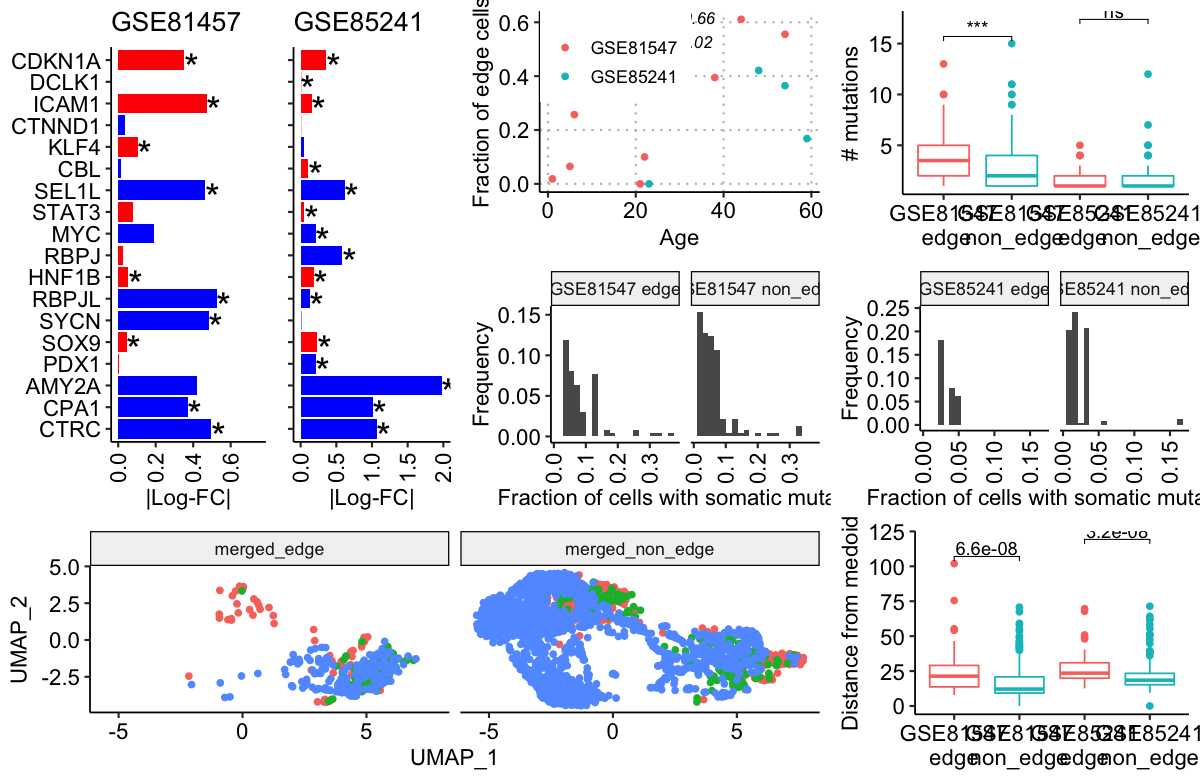

In [33]:
options(repr.plot.width=10,repr.plot.height=6.5)
Fig4_complete <- grid.arrange( arrangeGrob(grobs=
                          list(p_efsun_markers + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)
                                                                    ) + ggtitle("GSE81457"), 
                                     p_vano_markers + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
                                                           axis.text.y=element_blank()) + ggtitle("GSE85241"),
          edge_age_plot,combined_box_plot,
                                     gse81547_hist_plot + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)),
          gse85241_hist_plot + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)),
                                           p_edge_merged_umap + theme(legend.position="none"),
                                           p_merged_edge_pca),
                         nrow=3,ncol=4,
                           widths=c(0.75,0.5,1,1),
                           layout_matrix = rbind(c(1, 2, 3, 4),
                                                 c(1, 2, 5, 6),
                                          c(7,7,7,8)) ))
ggsave("Fig4_complete_new.svg",Fig4_complete,width=12,height=7.5)

## Lung data

In [330]:
source("../src/process_pdac.R")
lung_data <- load_lung_data()
for (normal_cell_type in c("Ciliated","Club","AT1","AT2")) {
    lung_edge_info <- run_edge_pipeline(lung_data$seurat_obj,normal_cell_types=normal_cell_type,
                  malignant_cell_types="tS2",pipeline_variant = "feature-selection",ident_to_use="cluster",
                                   sample_info_column="Sample", num_pcs=5)
}

lung_edge_info_list <- run_pc_wise_edge_analysis( lung_data$seurat_obj, normal_cell_types=c("Ciliated","Club","AT1","AT2"),
                                                 malignant_cell_type="tS2",ident_to_use="cluster",
                                                 sample_info_column="Sample")
mascaux_gene_sets <- c("MYC_TARGETS_V2","MYC_TARGETS_V1","MTORC1_SIGNALING","PI3K_AKT_MTOR_SIGNALING",
                      "E2F_TARGETS","MITOTIC_SPINDLE","INTERFERON_GAMMA_RESPONSE","ALLOGRAFT_REJECTION",
                      "G2M_CHECKPOINT","IL6_JAK_STAT3_SIGNALING","TNFA_SIGNALING_VIA_NFKB","INFLAMMATORY_RESPONSE",
                      "IL2_STAT5_SIGNALING","ADIPOGENESIS","EPITHELIAL_MESENCHYMAL_TRANSITION","UV_RESPONSE_UP","UV_RESPONSE_DN",
                      "OXIDATIVE_PHOSPHORYLATION","FATTY_ACID_METABOLISM","HYPOXIA")


[1] "Ciliated"
[1] "Club"


Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "normal_PC_1"
[1] "combined_PC_1"
[1] "--------"


Warning message in fgsea(pathways, sorted_gene_vec, nperm = 1000):
“There are ties in the preranked stats (61.49% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "AT1"


Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "normal_PC_1"
[1] "combined_PC_1"
[1] "--------"


Warning message in fgsea(pathways, sorted_gene_vec, nperm = 1000):
“There are ties in the preranked stats (67.25% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "normal_PC_2"
[1] "combined_PC_1"
[1] "--------"


Warning message in fgsea(pathways, sorted_gene_vec, nperm = 1000):
“There are ties in the preranked stats (67.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "AT2"


Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "normal_PC_5"
[1] "combined_PC_1"
[1] "--------"


Warning message in fgsea(pathways, sorted_gene_vec, nperm = 1000):
“There are ties in the preranked stats (52.4% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


## Liver data

In [335]:
liver_data <- load_liver_data()
for (normal_cell_type in paste0("Hep",1:6)) {
    liver_edge_info <- run_edge_pipeline(liver_data$seurat_obj,normal_cell_types=normal_cell_type,
                   malignant_cell_types="Malignant cell",pipeline_variant = "feature-selection",
                                      num_pcs=5, ident_to_use="Type",edge_cell_fraction=0.1,
                                    sample_info_column="Sample")
}
liver_edge_info_list <- run_pc_wise_edge_analysis( liver_data$seurat_obj, normal_cell_types=paste0("Hep",1:6),
                                                 malignant_cell_type="Malignant cell",ident_to_use="Type",
                                                 sample_info_column="Sample")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] "Feature selection mode"
[1] "Feature selection mode"


Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "Feature selection mode"


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.4976”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  5.0156e-15”
Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "Feature selection mode"
[1] "Feature selection mode"
[1] "Feature selection mode"


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.2035”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.32274”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.1054e-28”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.031008”
Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "Hep1"
[1] "Hep2"


Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "normal_PC_2"
[1] "combined_PC_1"
[1] "--------"


Warning message in fgsea(pathways, sorted_gene_vec, nperm = 1000):
“There are ties in the preranked stats (50.16% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Hep3"


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.4976”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  5.0156e-15”
Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



[1] "normal_PC_2"
[1] "combined_PC_2"
[1] "--------"


Warning message in fgsea(pathways, sorted_gene_vec, nperm = 1000):
“There are ties in the preranked stats (63.29% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Hep4"
[1] "Hep5"
[1] "Hep6"


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.2035”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.32274”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.1054e-28”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.031008”
Centering and scaling data matrix



[1] "Cannot shuffle PCs for skewness test since only a single PC is being used."


Centering and scaling data matrix



p-values of enrichment of Mascaux et. al gene sets amongst each of the edge-like populations

In [103]:
edge_info_list <- c(lung_edge_info_list,liver_edge_info_list)
combined_fgsea_dt <- data.table()
pathways <- load_pathways()
hallmark_pathways <- names(pathways)[grepl("HALLMARK_",names(pathways))] %>% gsub("HALLMARK_","",.)
num_hallmark <- sum(grepl("HALLMARK",names(pathways)))
p_values <- c()
for (cell_type in names(edge_info_list)) {
    edge_info <- edge_info_list[[cell_type]]
    for (normal_pc in names(edge_info)) {
        dt <- edge_info[[normal_pc]]$fgsea_dt 
        combined_fgsea_dt <- rbind(combined_fgsea_dt,
                                   edge_info[[normal_pc]]$fgsea_dt %>% mutate(cell_type=paste(cell_type,normal_pc,sep="_")))
        
        dt <- dt[grepl("HALLMARK",pathway),]
        enriched_pathways <- dt[padj < 0.1,pathway] %>% gsub("HALLMARK_","",.)
        not_enriched_pathways <- dt[padj >= 0.1,pathway] %>% gsub("HALLMARK_","",.)
        num_in_pc_in_mascaux <- length(intersect(enriched_pathways,mascaux_gene_sets))
        num_in_pc_not_in_mascaux <- length(intersect(enriched_pathways,setdiff(hallmark_pathways,mascaux_gene_sets)))
        num_not_in_pc_in_mascaux <- length(intersect(not_enriched_pathways,mascaux_gene_sets))
        num_not_in_pc_not_in_mascaux <- length(intersect(not_enriched_pathways,setdiff(hallmark_pathways,mascaux_gene_sets)))
        fisher_res <- fisher.test(matrix(c(num_in_pc_in_mascaux,num_in_pc_not_in_mascaux,
                                          num_not_in_pc_in_mascaux,num_not_in_pc_not_in_mascaux),
                                 nrow=2,ncol=2,byrow=T),alternative="g")
        print(cell_type)
        print(normal_pc)
        print(fisher_res$p.value)
        p_values <- c(p_values,fisher_res$p.value)
        flush.console()
    }
}

disp_fgsea_mat <- combined_fgsea_dt[,.(pathway,padj,NES,cell_type)] %>% mutate(NES=ifelse(padj < 0.05,NES,NA)) %>%
dplyr::select(-padj) %>% tidyr::pivot_wider(names_from="cell_type",values_from="NES") %>%
tibble::column_to_rownames("pathway") %>% as.matrix

[1] "Club"
[1] "normal_PC_1"
[1] 0.3866436
[1] "AT1"
[1] "normal_PC_1"
[1] 0.1722291
[1] "AT1"
[1] "normal_PC_2"
[1] 0.04247541
[1] "AT2"
[1] "normal_PC_5"
[1] 0.05048979
[1] "Hep2"
[1] "normal_PC_2"
[1] 0.3549731
[1] "Hep3"
[1] "normal_PC_2"
[1] 0.1643386


## Figure 5B, S3D

In [120]:
mascaux_mat <- disp_fgsea_mat[paste("HALLMARK",mascaux_gene_sets,sep="_"),]
vec <- na.omit(as.vector(mascaux_mat))
colors <- colorRamp2(c(min(vec),max(vec)),c("#ffa500","#ff0000"))
values <- c(1.2,1.4,1.6,1.8,2)
p_heatmap <- Heatmap(mascaux_mat,cluster_rows=F,cluster_columns=F,
        name="Norm. Enrichment\nScore",
                     na_col="white", 
       rect_gp = gpar(col = "black", lwd = 2))
ggsave( "Fig5b.svg", grid.grabExpr(draw(p_heatmap)), width=6.5, height=7 )

p_heatmap_full <- Heatmap(disp_fgsea_mat[rowSums(is.na(disp_fgsea_mat)) < 6,],cluster_rows=F,cluster_columns=F,
        name="Norm. Enrichment\nScore",
                     na_col="white", 
       rect_gp = gpar(col = "black", lwd = 1), column_names_gp=gpar(fontsize=8),
                         row_names_gp=gpar(fontsize=8))
ggsave( "Fig-S3D.svg", grid.grabExpr(draw(p_heatmap_full)), width=5, height=8 )

## Figure 5A display

In [461]:
lung_edge_features <- readRDS("sample_aware_AT2_tS2_RNA_analysis.rds")

skewness_dt <- lung_edge_features$skewness_p_value[order(-p_value),] %>% 
mutate(Var1=gsub("normal_","",Var1) %>% gsub("_","",.)) %>% tail(10)     
skewness_dt$Var1 <- factor(skewness_dt$Var1,levels=skewness_dt$Var1)
p_skew <- ggplot( skewness_dt[,significant:=fifelse(q_value < 0.1,TRUE,FALSE)] ) + 
geom_bar(aes(x=Var1,y=value,fill=significant),stat="identity") + coord_flip() +
theme_pubr(base_size=10) + xlab("Normal PC") + ylab("Skewness")

edge_distance_dt <- lung_edge_features$edge_center_p_value[normal_pc == "normal_PC_1",][order(-p_value),] %>% 
mutate(pc=gsub("combined_","",pc) %>% gsub("_","",.)) %>% tail(10)     
edge_distance_dt$pc <- factor(edge_distance_dt$pc,levels=edge_distance_dt$pc)
p_ratio <- ggplot( edge_distance_dt[,significant:=fifelse(q_value < 0.1,TRUE,FALSE)] ) + 
geom_bar(aes(x=pc,y=edge_center_dist_ratio,fill=significant),stat="identity") + coord_flip() +
theme_pubr(base_size=10) + xlab("Pooled PC") + ylab("Proximity Ratio\n(Outliers defined using Normal PC5)")

main_pca_cor_df <- get_pca_correlations( lung_edge_info$normal_pca, lung_edge_info$combined_pca ) %>% 
dplyr::select(Var1,Var2,cor,q_value) %>% dplyr::filter(Var1=="normal_PC_5") %>%
mutate(Var1=gsub("normal_","",Var1) %>% gsub("_","",.),
       Var2=gsub("combined_","",Var2) %>% gsub("_","",.) ) %>%
mutate(significant=ifelse(q_value < 0.1,TRUE,FALSE)) %>% dplyr::filter(Var2 %in% paste0("PC",1:10))

p_pca_cor <- ggplot( main_pca_cor_df %>% mutate(significant=ifelse(q_value < 0.1,TRUE,FALSE) )) + 
geom_bar(aes(x=Var2,y=cor,fill=significant),stat="identity") + coord_flip() +
theme_pubr(base_size=10) + xlab("Normal PC") + ylab("Corr. with Normal PC5")

fig5a <- ggarrange( p_skew + theme(legend.position="none"), 
          p_ratio + theme(legend.position="none"), 
          p_pca_cor + theme(legend.position="none"), nrow=3, ncol=1 )
ggsave("Fig5a.svg",fig5a,width=3,height=6.5)